In [1]:
import numpy as np
import fitsio
import healpy as hp
import matplotlib.pyplot as plt
import Config

In [2]:
condFiles = []

for file in Config.orgAirFiles:
    condFiles.append(file)
    
for file in Config.orgExpFiles:
    condFiles.append(file)

for file in Config.orgVarFiles:
    condFiles.append(file)
    
for file in Config.orgBriFiles:
    condFiles.append(file)
    
for file in Config.orgSeeFiles:
    condFiles.append(file)
    
for file in Config.orgZptFiles:
    condFiles.append(file)
    
condFiles.append(Config.orgDensFile)

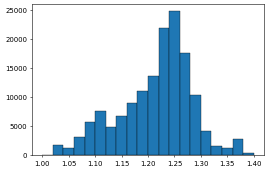

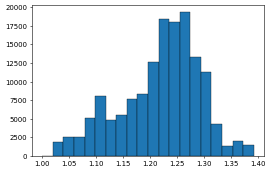

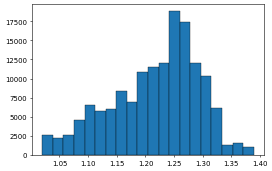

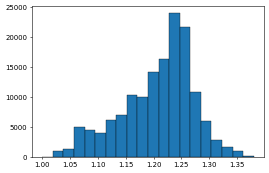

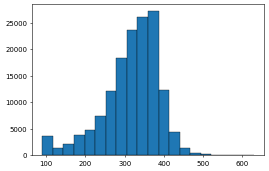

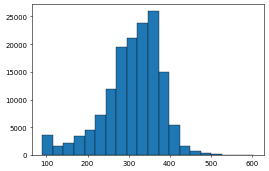

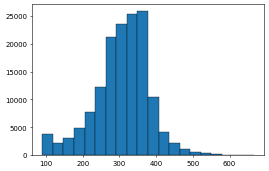

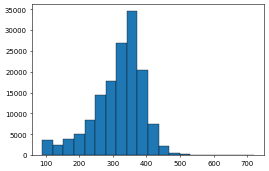

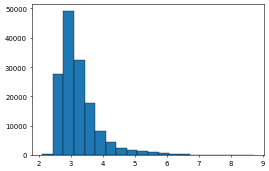

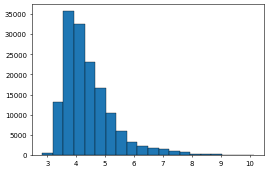

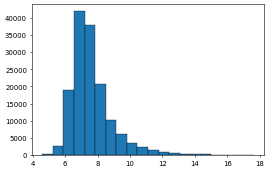

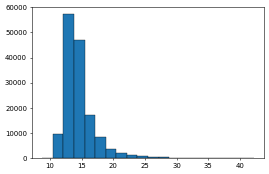

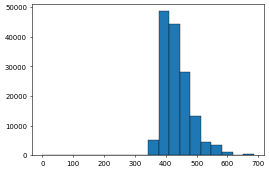

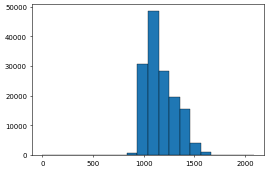

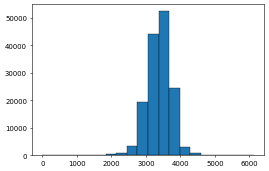

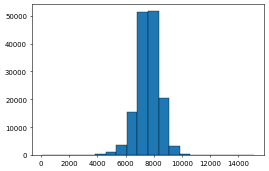

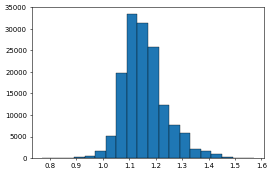

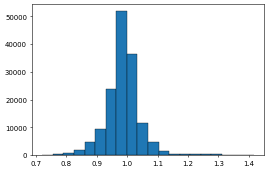

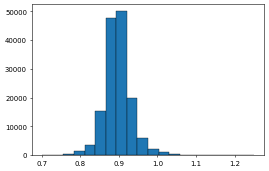

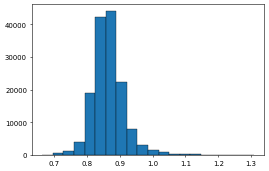

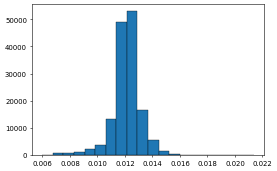

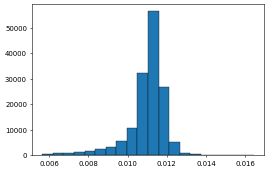

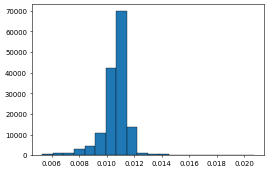

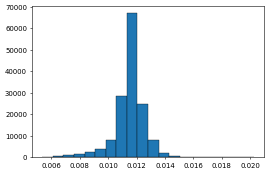

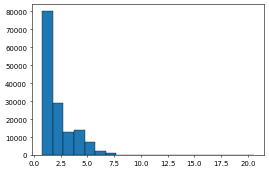

In [3]:
condSigsExt = []

for file in condFiles:
    condMap = hp.fitsfunc.read_map(file, nest = True)
    condMap[condMap==-1.6375e+30]=hp.UNSEEN
    condSigExt=hp.ud_grade(condMap,256)
    condSig = condSigExt[np.where(condSigExt >= 0)[0]]
    condSigsExt.append(condSigExt)
    plt.figure(dpi = 50)
    plt.hist(condSig, bins = 20, edgecolor='black', linewidth=.5)
    plt.show()
    
condSigsExt = np.array(condSigsExt)

In [26]:
starFile = '/afs/hep.wisc.edu/bechtol-group/MegansThings/balrog_detection_catalog_sof_run2_stars_v1.4_avg_added_match_flags.fits'
# This reads in all of the data. Most of these are just flags, the only pieces that get used much outside
# of filtering are true_ra and true_dec which get used to convert into healPixels.
starData = fitsio.read(starFile, columns = ['detected', 'true_ra', 'true_dec',
                                            'flags_foreground', 'flags_badregions', 'flags_footprint',
                                            'meas_FLAGS_GOLD_SOF_ONLY', 'match_flag_1.5_asec'])
# These are in degrees which is why lonlat is set to True in the next cell.
RA = starData['true_ra']
DEC = starData['true_dec']
# Everything from here on out is simply used in order to filter the data
DETECTED = starData['detected'] # This specifically is used for now to filter out any non detected injection.
FOREGROUND = starData['flags_foreground']
BADREGIONS = starData['flags_badregions']
FOOTPRINT = starData['flags_footprint']
GOLDSOF = starData['meas_FLAGS_GOLD_SOF_ONLY']
ARCSECONDS = starData['match_flag_1.5_asec']
# i_mag = starData['meas_cm_mag_deredden'][:,2] This gets used if we filter at all based on i magnitude.

# This is used to filter out any injections that either weren't detected or had flags raised.
cutIndices = np.where((FOREGROUND == 0) & 
                      (BADREGIONS < 2) & 
                      (FOOTPRINT == 1) & 
                      # (GOLDSOF < 2) &
                      (ARCSECONDS < 2))[0]

# aveEff = np.sum(DETECTED) / len(DETECTED)

DETECTED = DETECTED[cutIndices]
RA = RA[cutIndices]
DEC = DEC[cutIndices]
# This converts the RA and DEC values from above to healpixels so we can compare to the sky condition.
starPixels = hp.ang2pix(256, RA, DEC, lonlat = True, nest = True)

In [27]:
validPixels = np.full(12*(256**2), False, dtype = bool)
validPixels[starPixels] = True
# This gets the indices of the stars that are at valid pixels (this shouldn't filter out many at all).
starIndices = np.where(validPixels[starPixels])[0]

In [28]:
# This tells me which pixels correspond to the values above.
condPix = np.where(validPixels)[0]

# This tells me the pixels for the stars, it will be the same as condPix but have repeats if multiple stars are detected
# on one pixel. By default these will not be sorted.
starPix = starPixels[starIndices]
DETVALIDPIX = DETECTED[starIndices]

# This sorts the pixels. This may seem like an unnecessarily difficult way to do it but it could be useful for future projects
# and it doesn't take much more space or time so I chose to leave it in.
sortInds = starPix.argsort()
starPix = starPix[sortInds[::1]]
DET = DETVALIDPIX[sortInds[::1]]

In [29]:
# These are indices that will be looping through the condPix and starPix arrays in parallel.
condInd = 0
starInd = 0

# This will be used to store the number of stars at each pixel.
detStar = np.zeros_like(condPix) + 1 # Laplace's Rule of Succession
injStar = np.zeros_like(condPix) + 2 # Laplace's Rule of Succession

while starInd < len(starPix):
    if condPix[condInd] == starPix[starInd]: # If the pixels match up in the arrays.
        detStar[condInd] += DET[starInd]
        injStar[condInd] += 1                # Add one to the corresponding spot in the balStar array.
        starInd += 1                         # Add one to the starInd to see if the next index in starPix is also the same.
        # Since the last index of condPix and starPix are the same, starInd will increase the last time through the loop,
        # making this the index that we must restrict in the while loop.
    else:
        condInd += 1 # If the pixels are no longer the same, increase the index you check in the condPix array.

In [30]:
aveEff = np.sum(detStar) / np.sum(injStar)
aveEff

0.7462268421718964

In [31]:
np.where(validPixels & (condSigsExt[-1] < 0))[0]

array([362506, 362528, 362530])

In [9]:
stelDensValid = np.where(condSigsExt[-1] >= 0)[0]
tempValidPix = np.full(12*(256**2), False, dtype = bool)
tempValidPix[stelDensValid] = True

print(np.sum(validPixels))

validPixels = validPixels & tempValidPix

print(np.sum(validPixels))

24604
24601


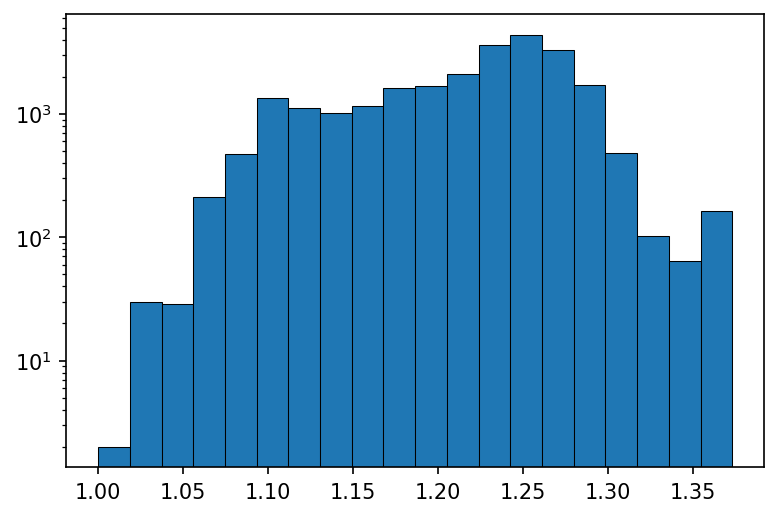

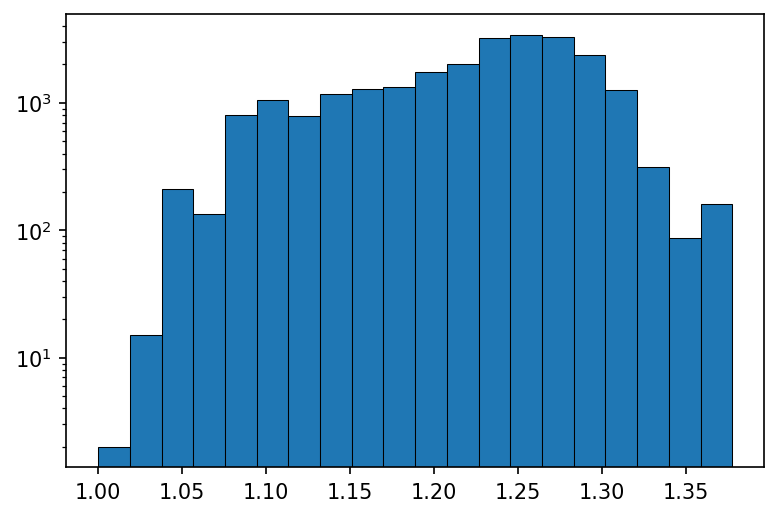

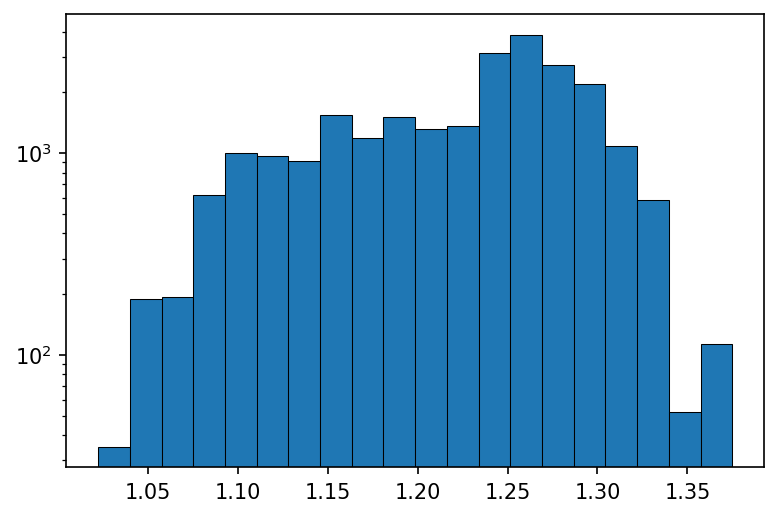

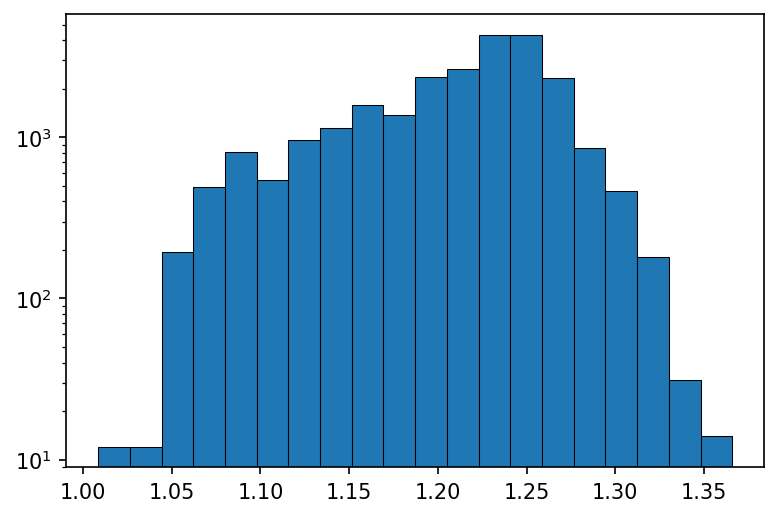

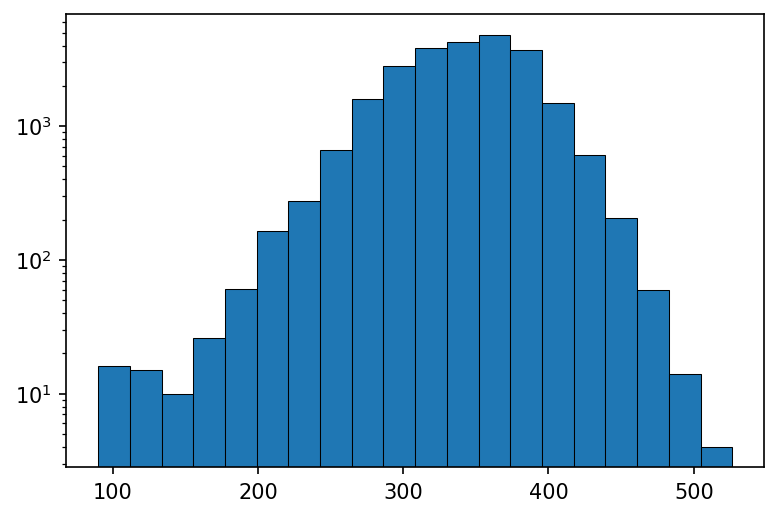

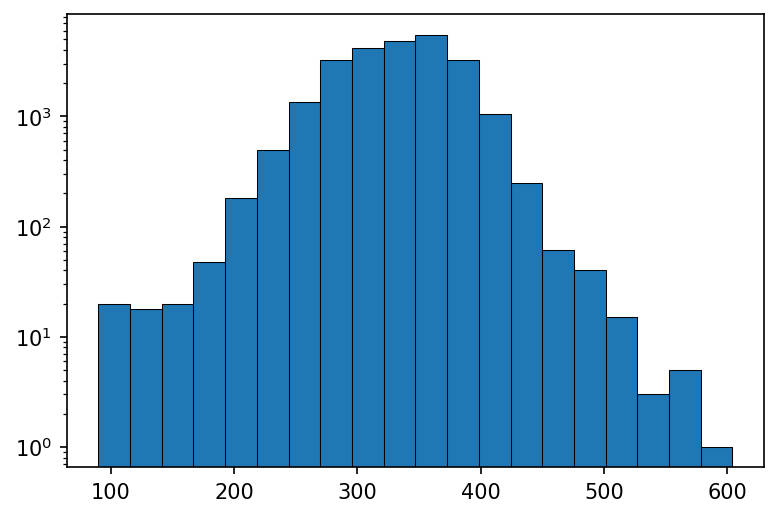

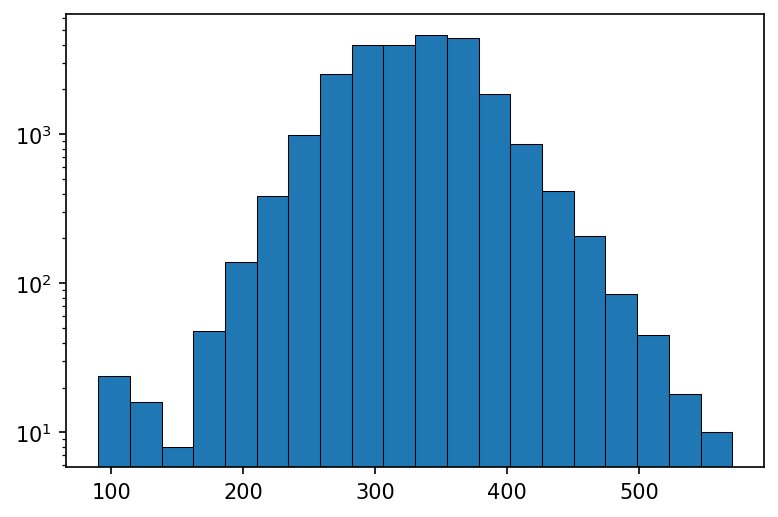

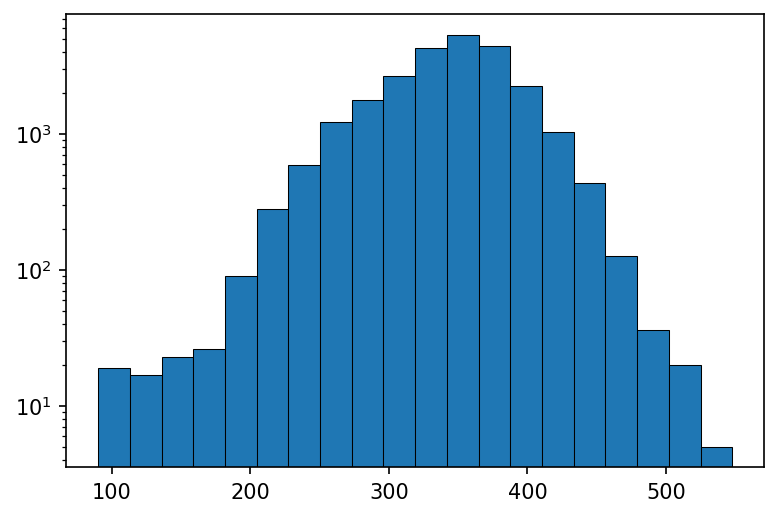

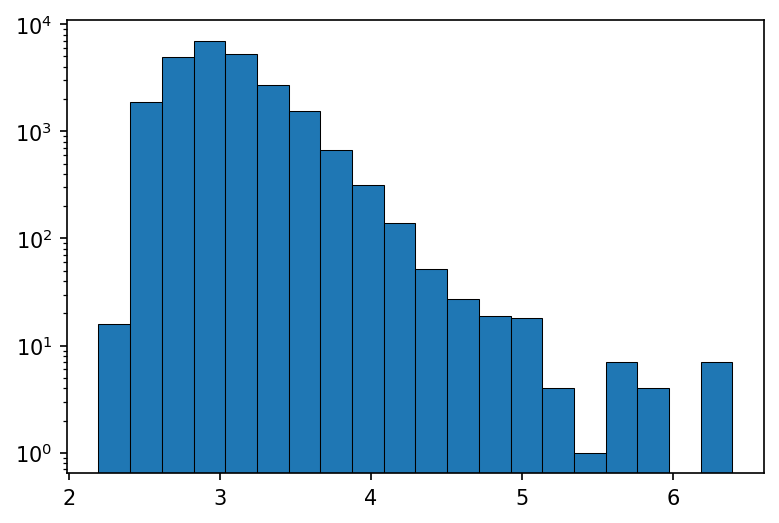

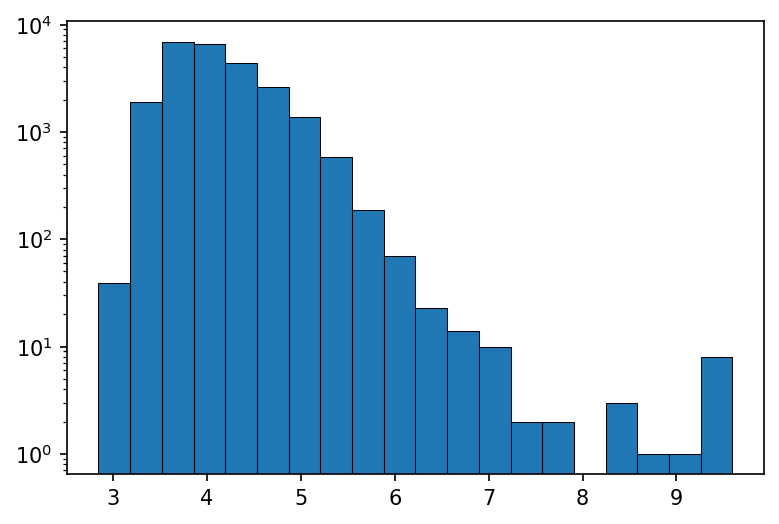

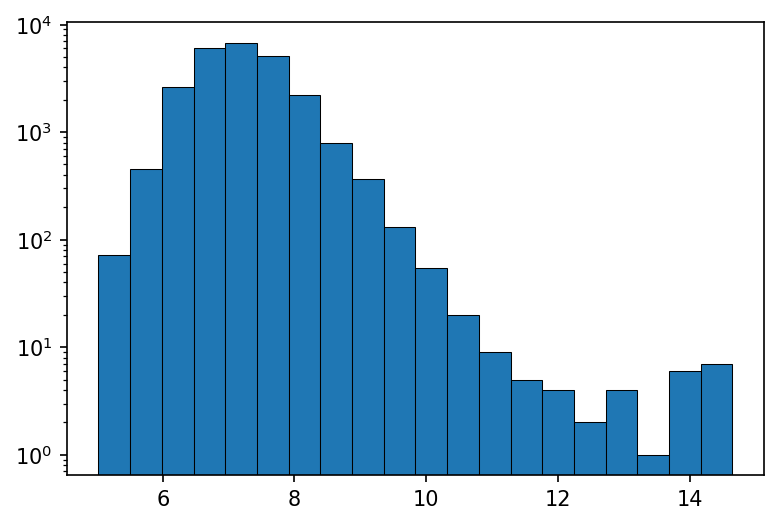

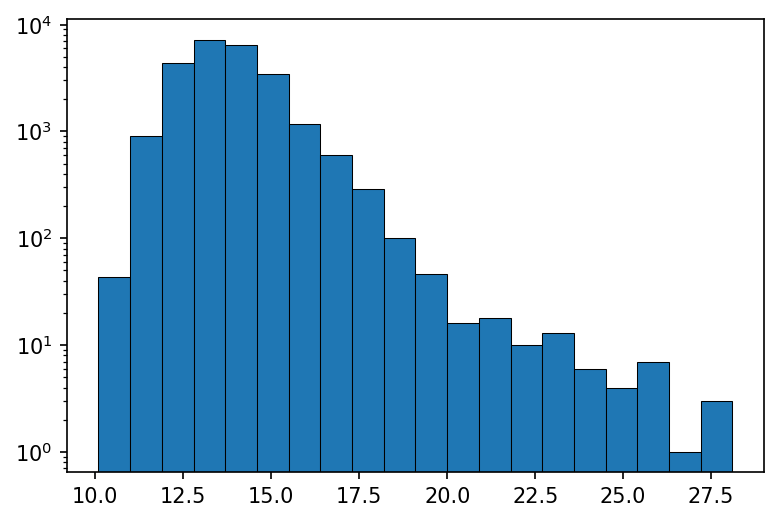

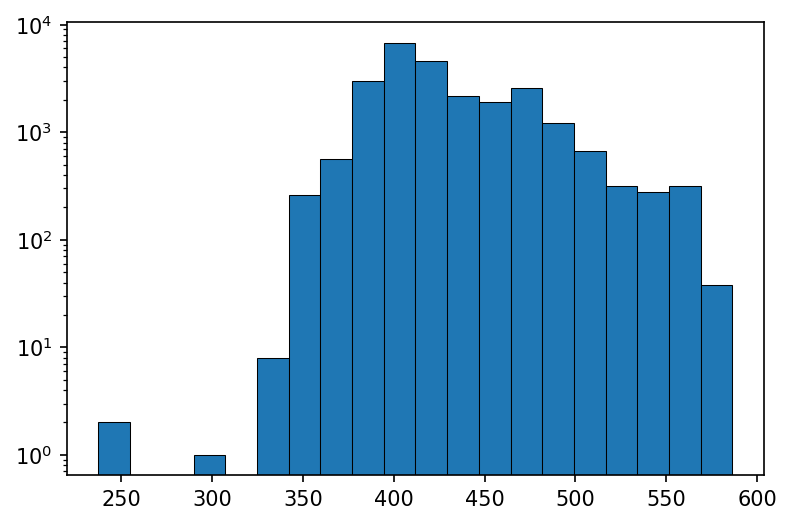

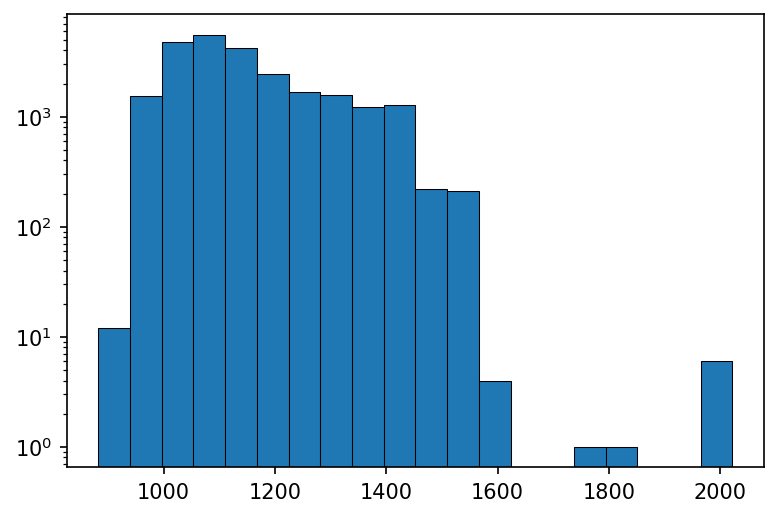

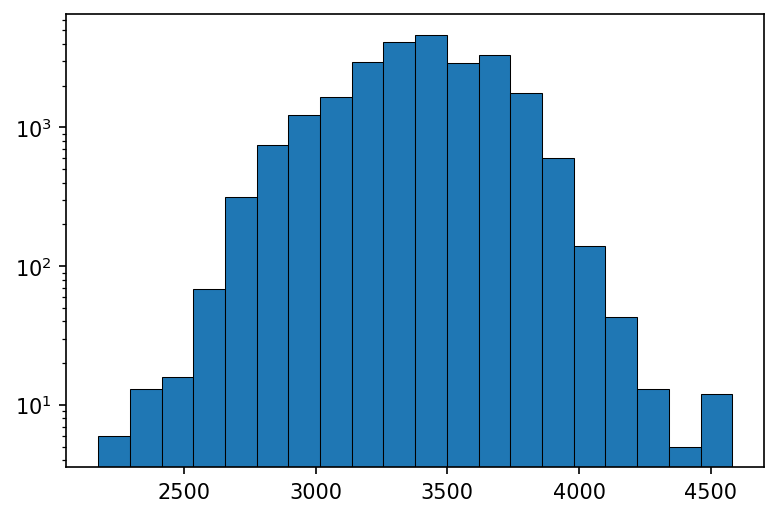

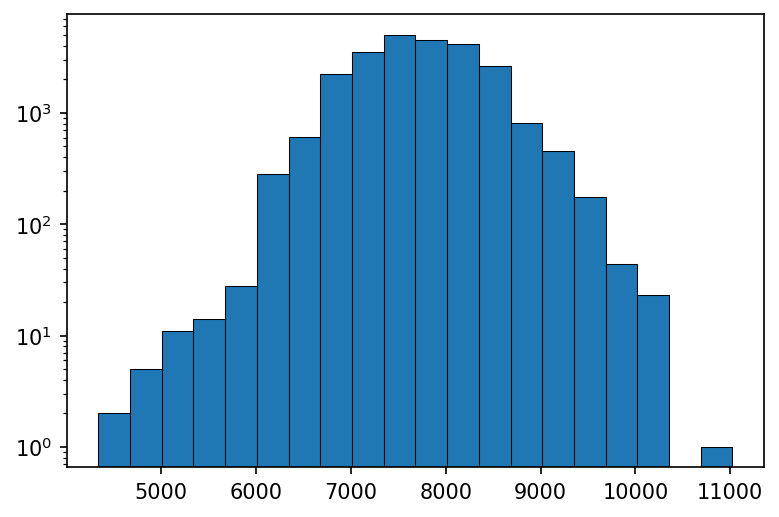

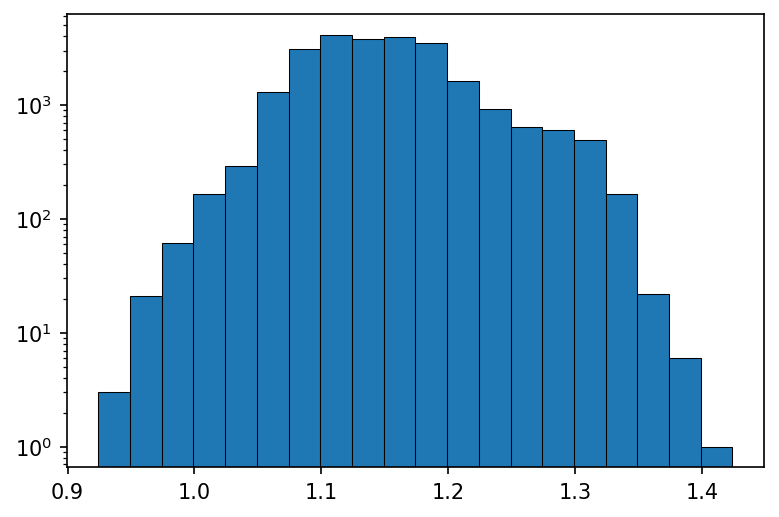

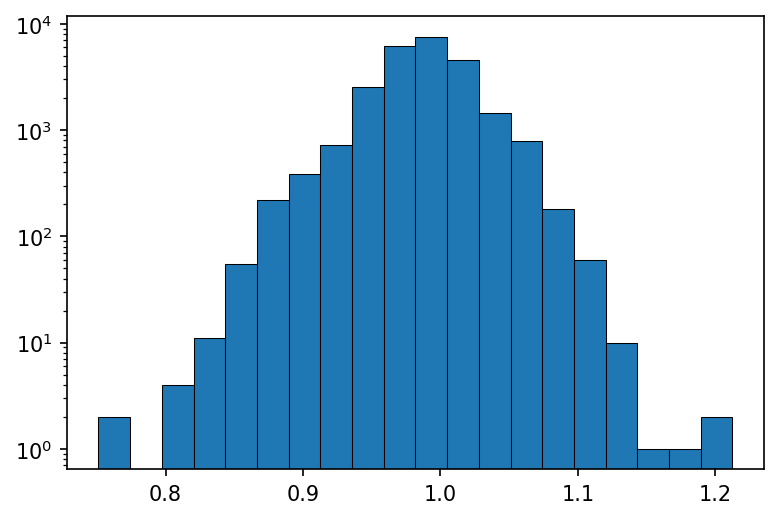

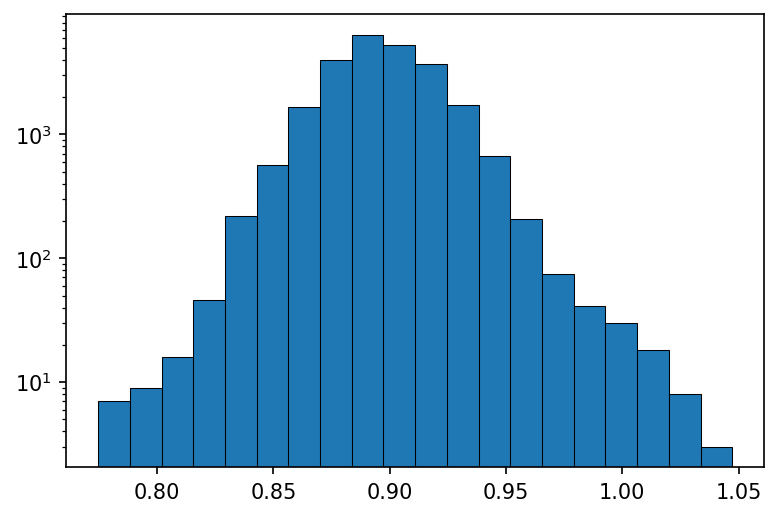

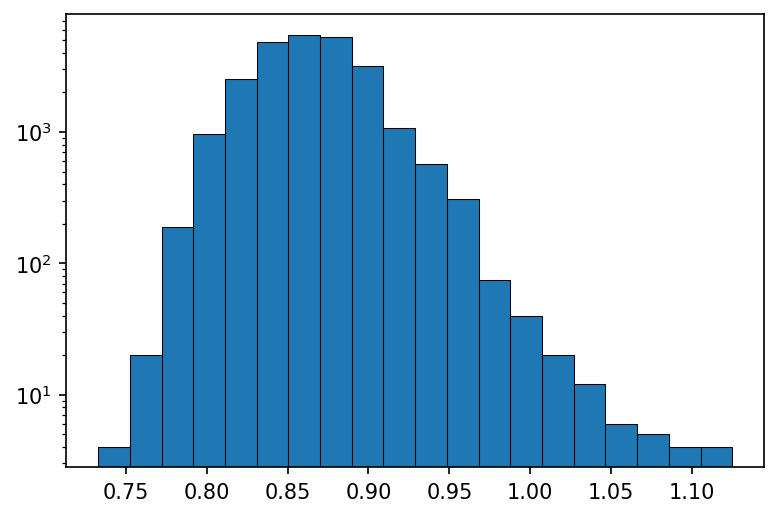

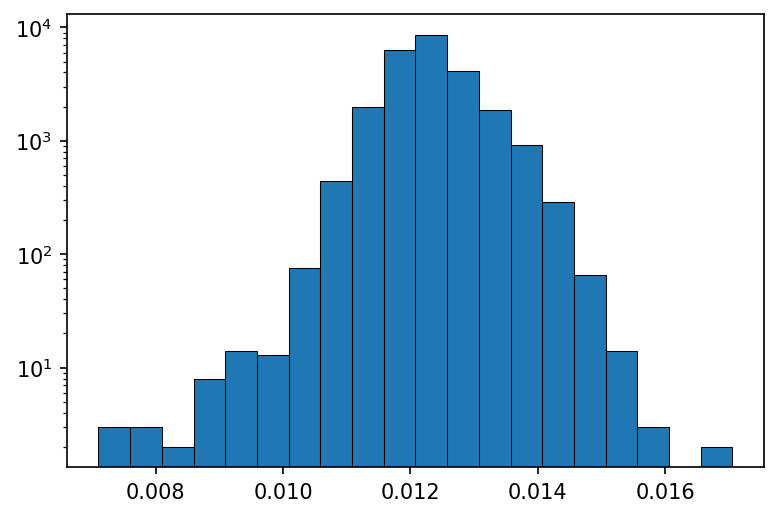

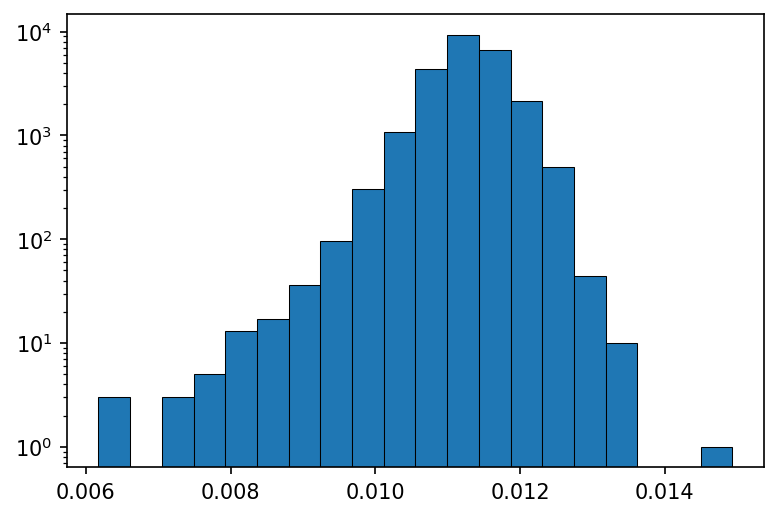

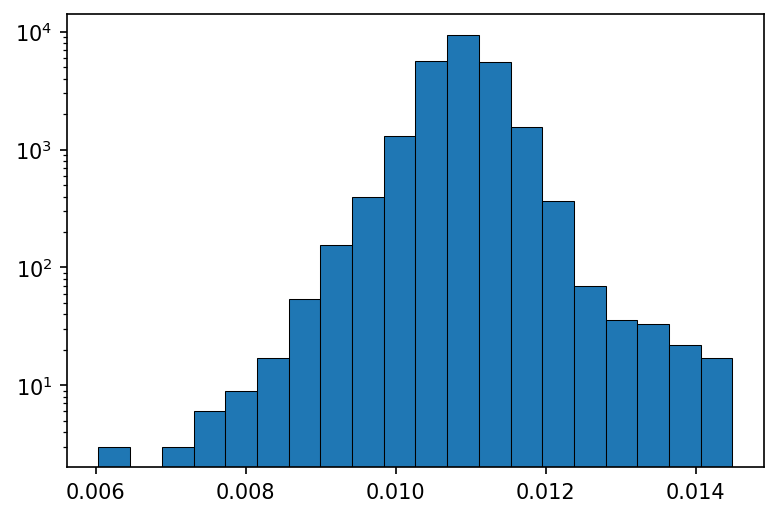

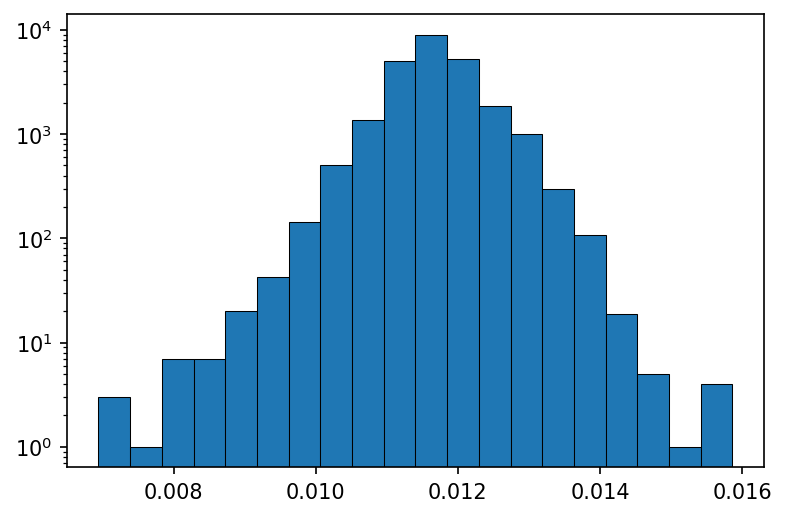

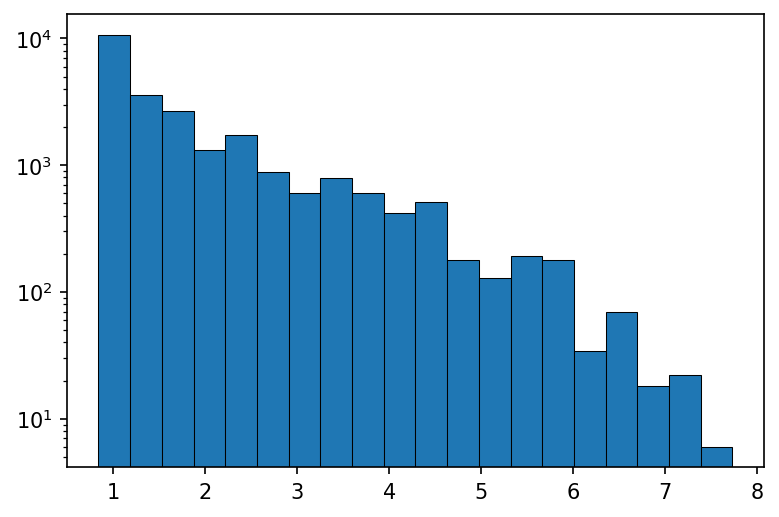

In [10]:
for cond in condSigsExt:
    condSig = cond[validPixels]
    plt.figure(dpi = 150)
    plt.hist(condSig, bins = 20, edgecolor='black', linewidth=.5)
    plt.yscale('log')
    plt.show()

In [11]:
pixelsUsed = np.where(validPixels)[0]

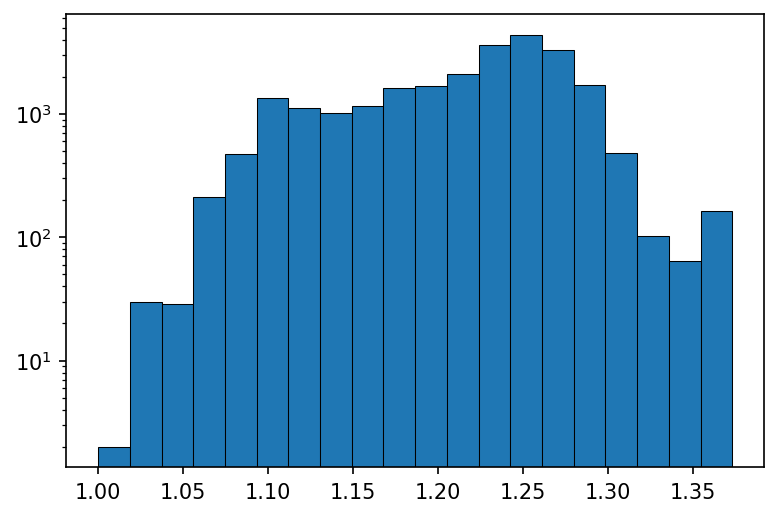

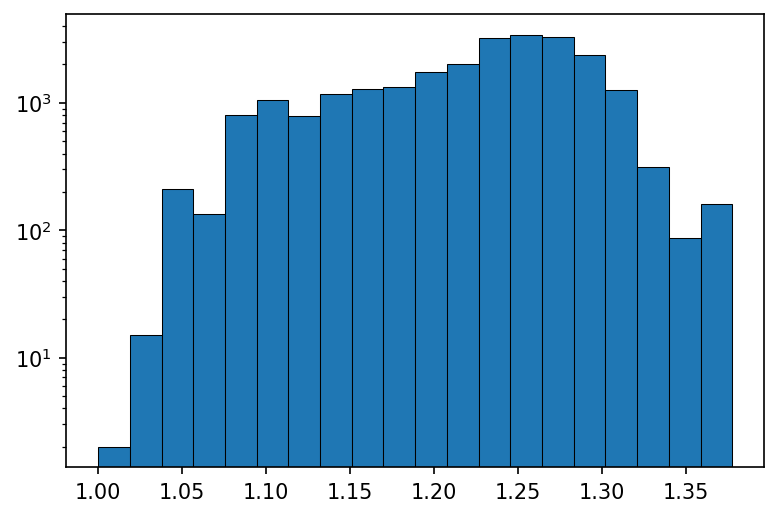

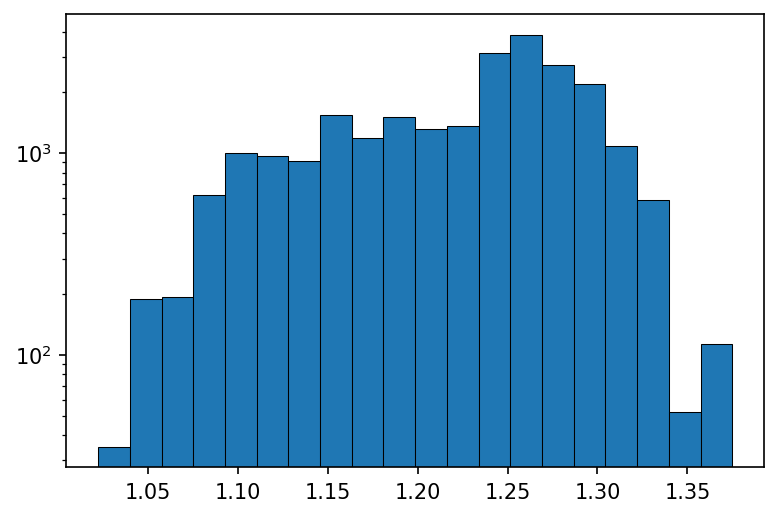

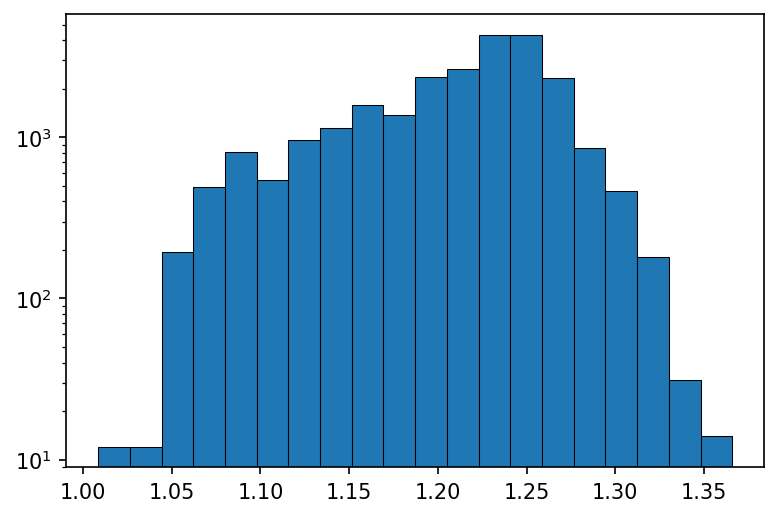

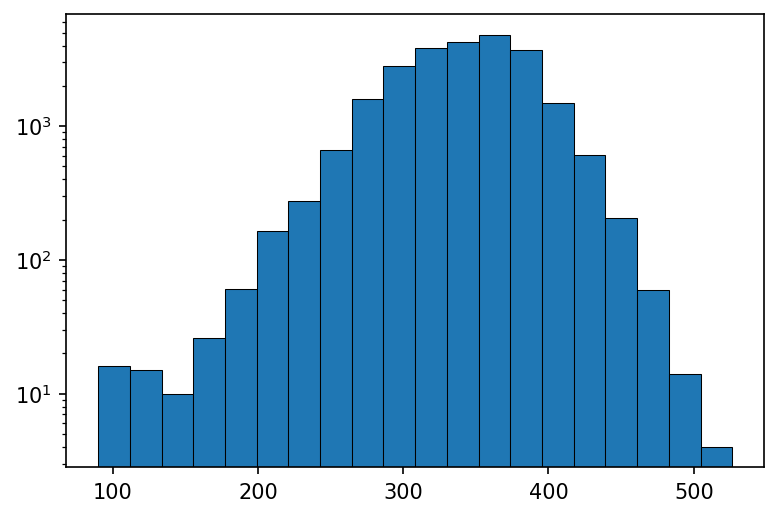

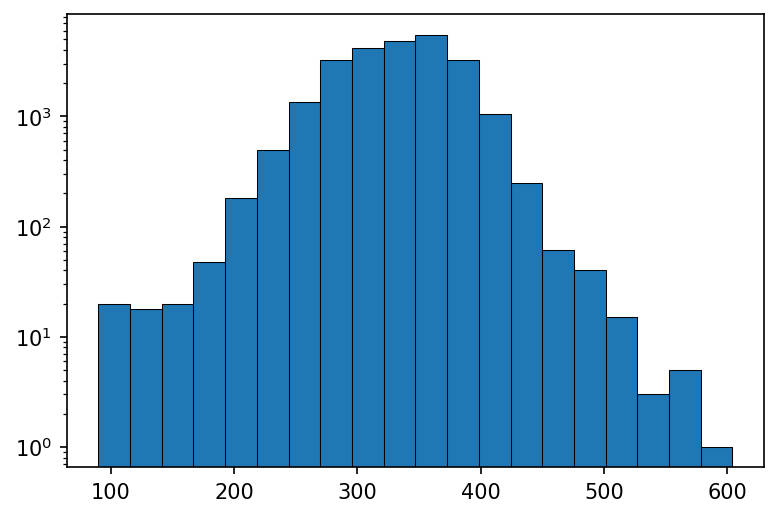

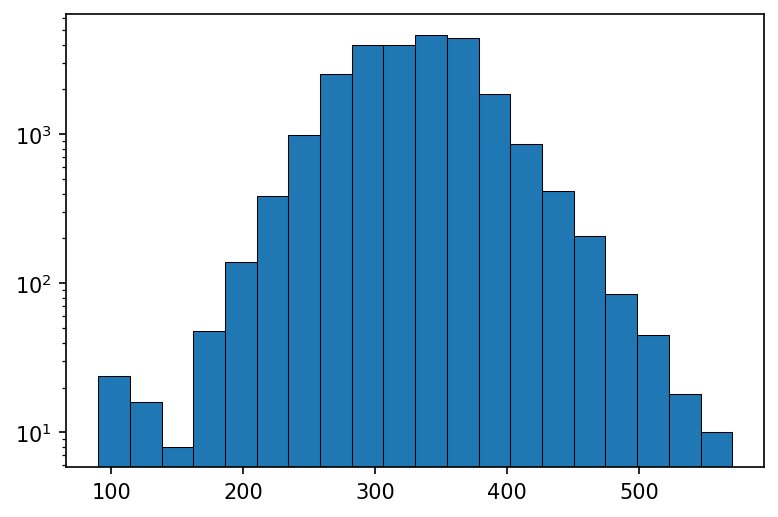

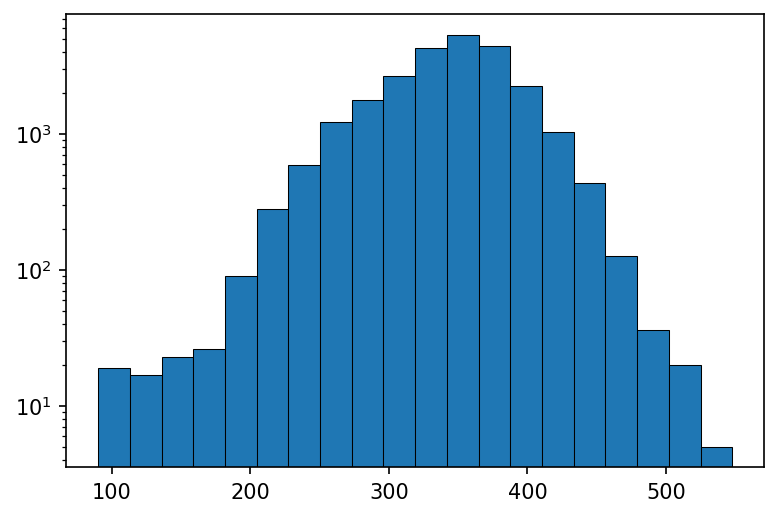

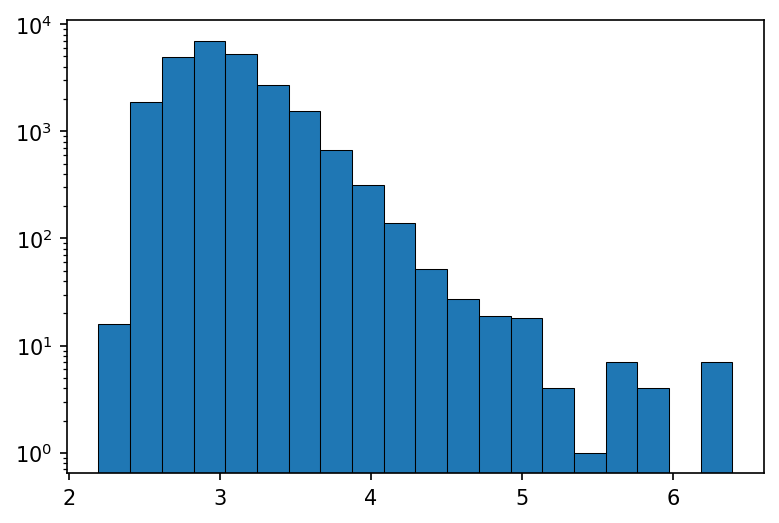

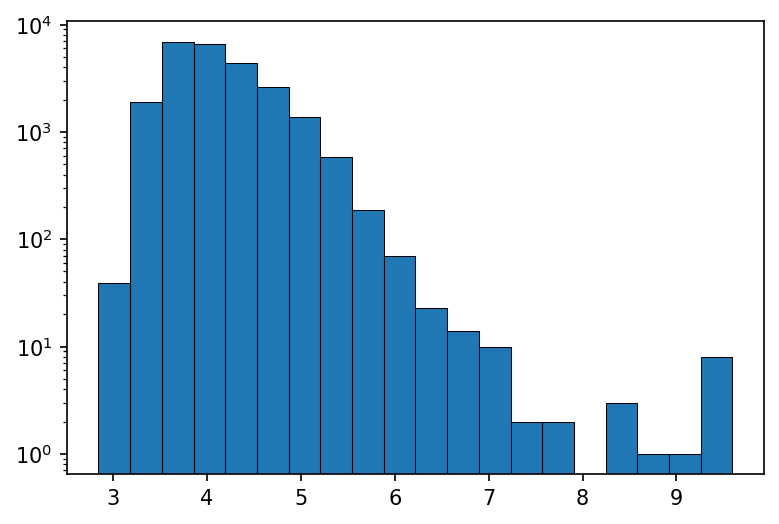

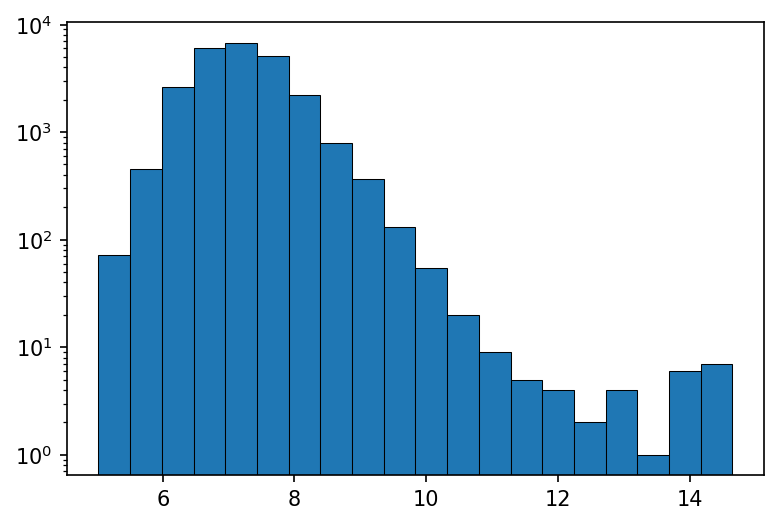

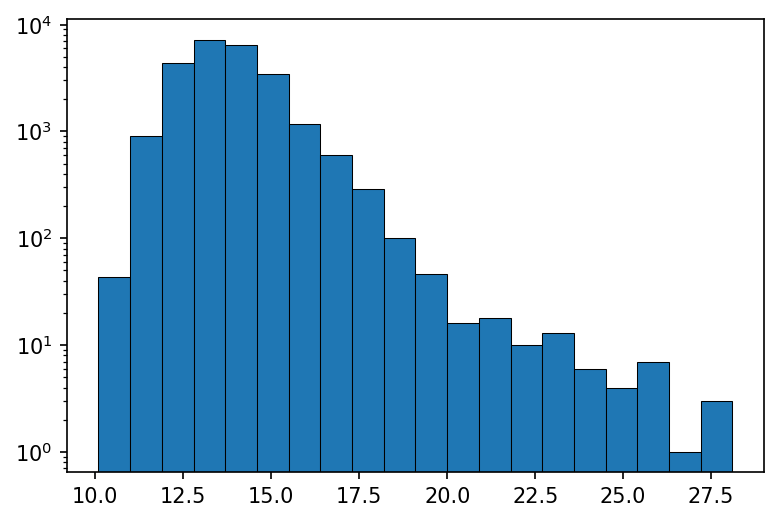

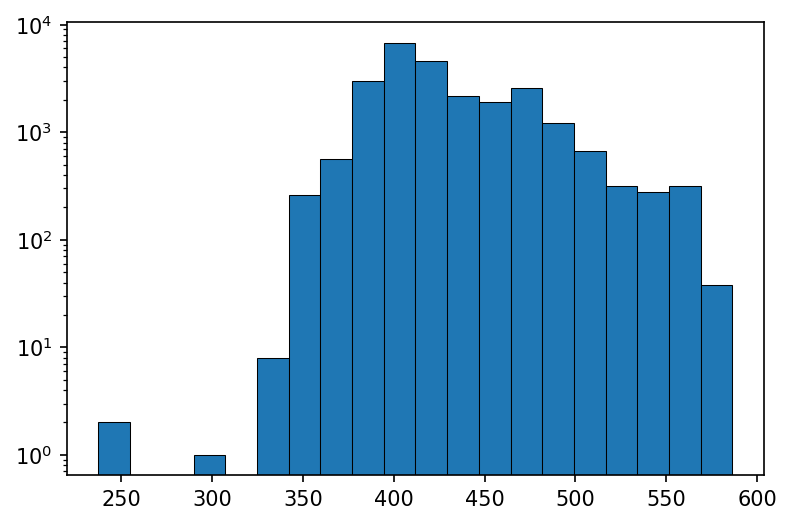

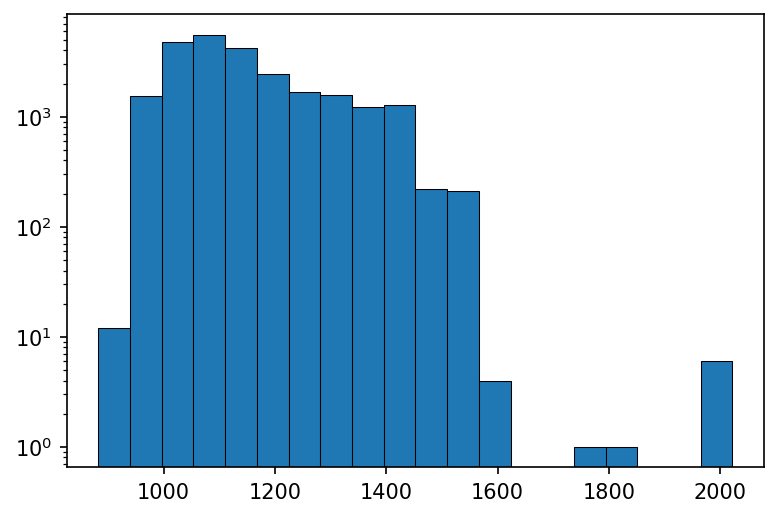

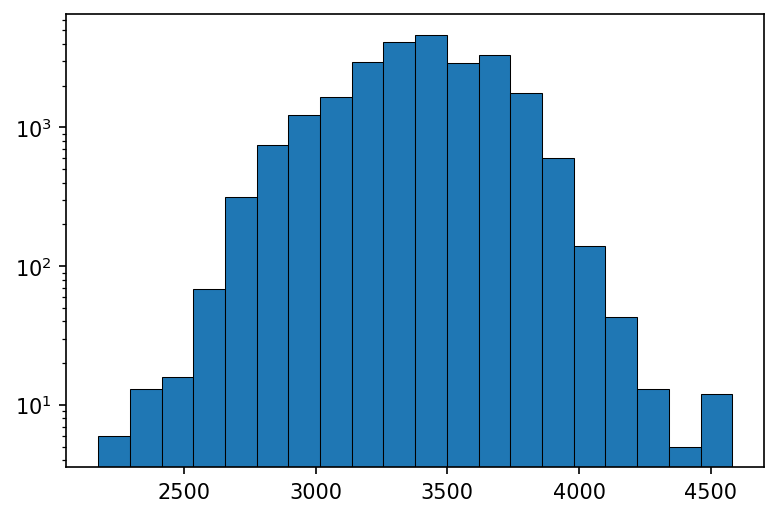

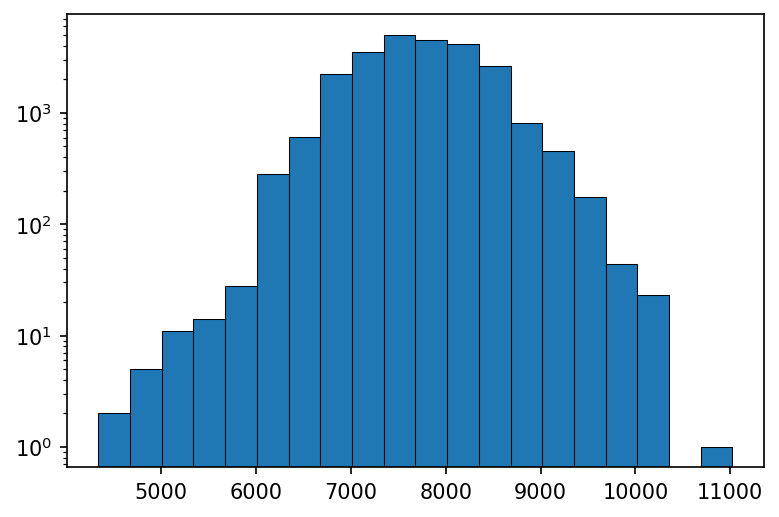

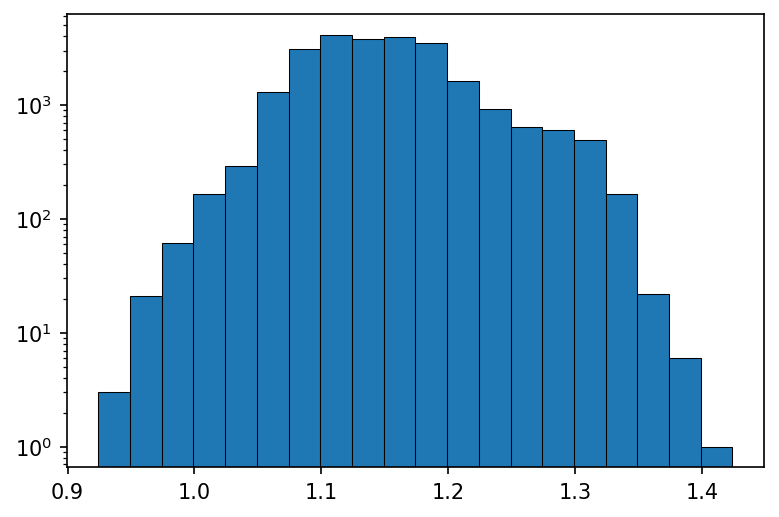

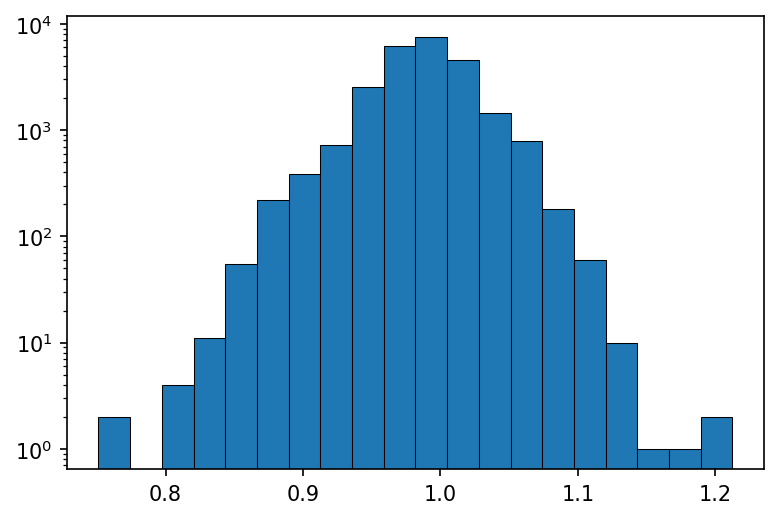

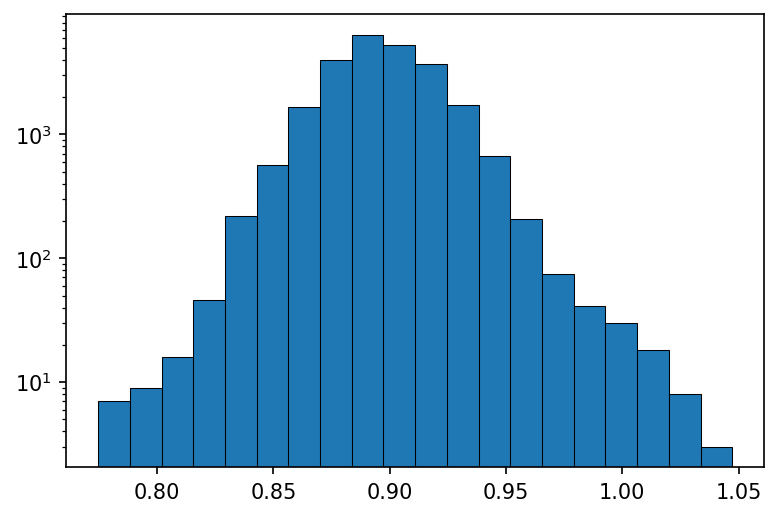

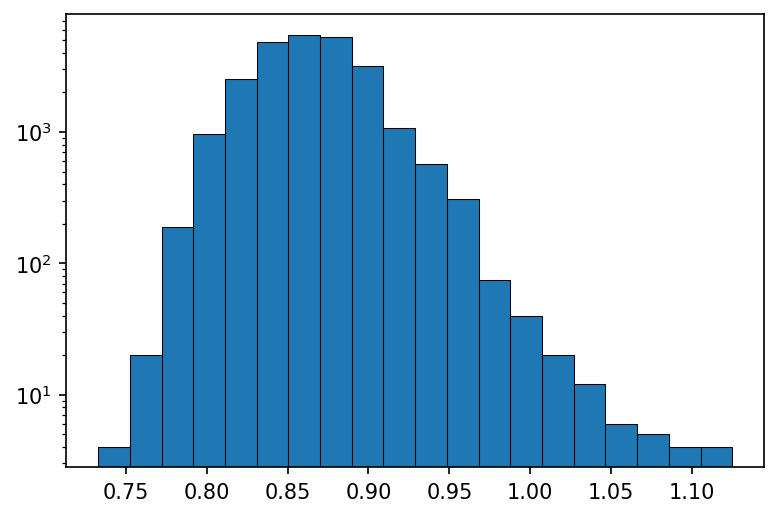

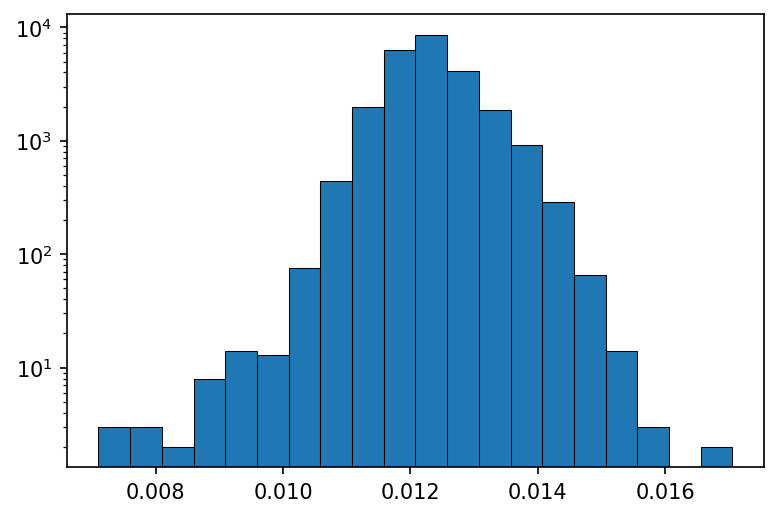

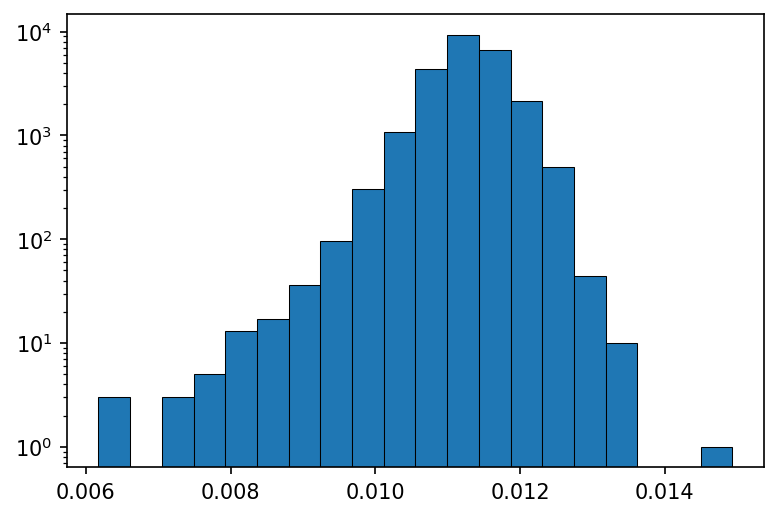

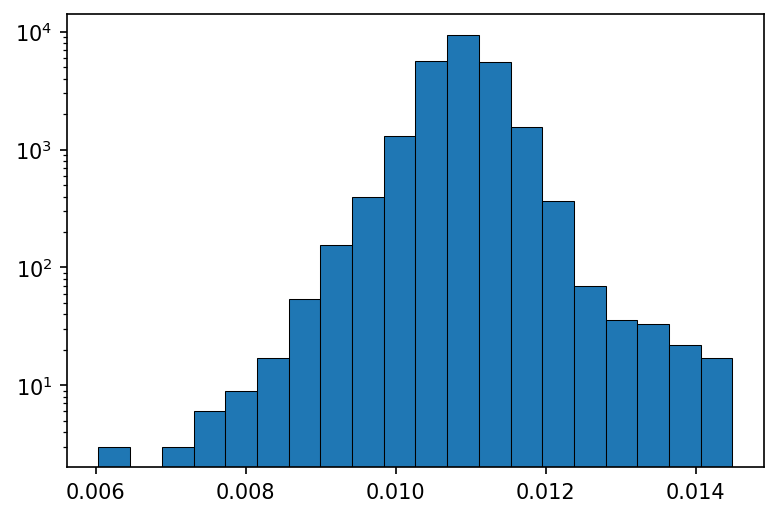

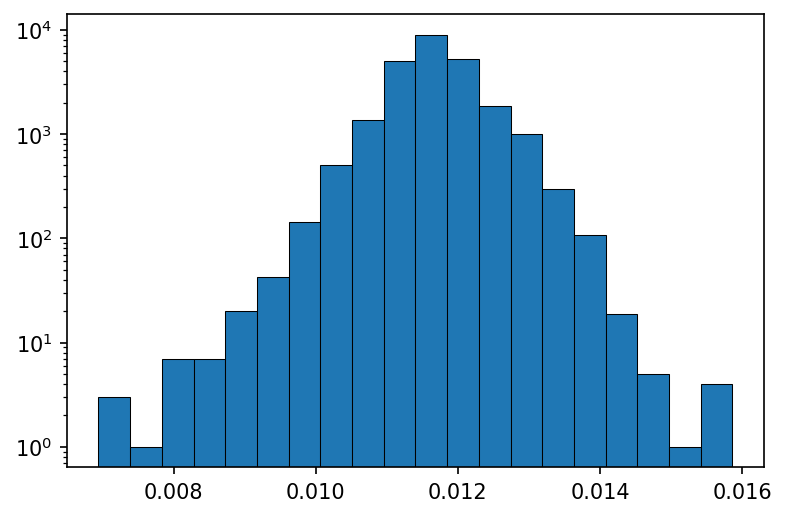

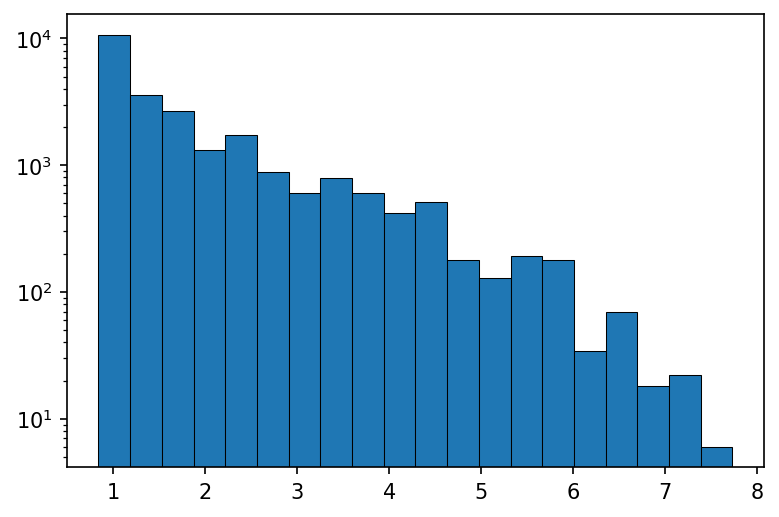

In [12]:
condStarPix = []

for cond in condSigsExt:
    condSig = cond[pixelsUsed]
    condStarPix.append(condSig)
    plt.figure(dpi = 150)
    plt.hist(condSig, bins = 20, edgecolor='black', linewidth=.5)
    plt.yscale('log')
    plt.show()
    
condStarPix = np.array(condStarPix)

In [13]:
# With this length cut off about 608 from each side to get down to 95%.
cutLen = int(np.round(0.025 * len(pixelsUsed)))

In [14]:
cond95Per = []
cond95PerPixels = []
binLims = []

for cond in condStarPix:
    sortedCond = np.sort(cond)
    minCond = sortedCond[cutLen]
    maxCond = sortedCond[len(pixelsUsed) - cutLen - 2]
    binLims.append(np.array([minCond, maxCond]))
    cond95Per.append(cond[np.where((cond >= minCond) & (cond <= maxCond))[0]])
    cond95PerPixels.append(pixelsUsed[np.where((cond >= minCond) & (cond <= maxCond))[0]])

In [15]:
VP = np.full(12*(256**2), True, dtype = bool)

for pix in cond95PerPixels:
    VPTemp = np.full(12*(256**2), False, dtype = bool)
    VPTemp[pix] = True
    VP = VP & VPTemp

In [16]:
np.sum(VP)

13937

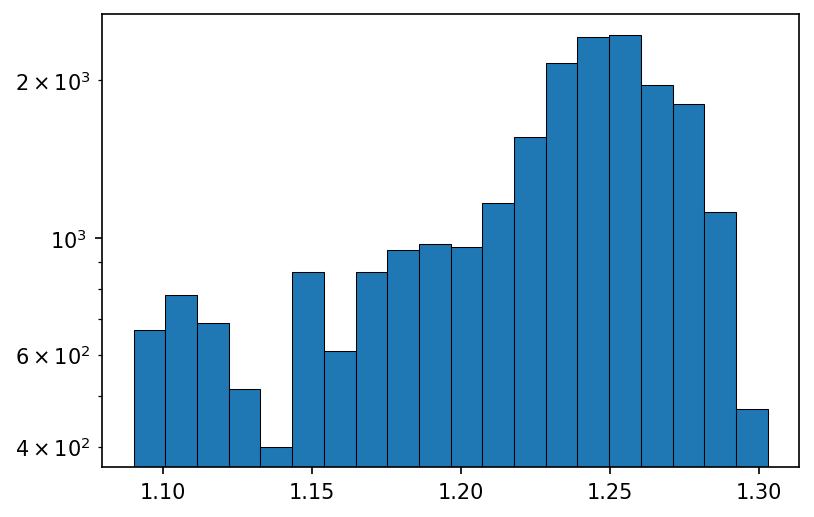

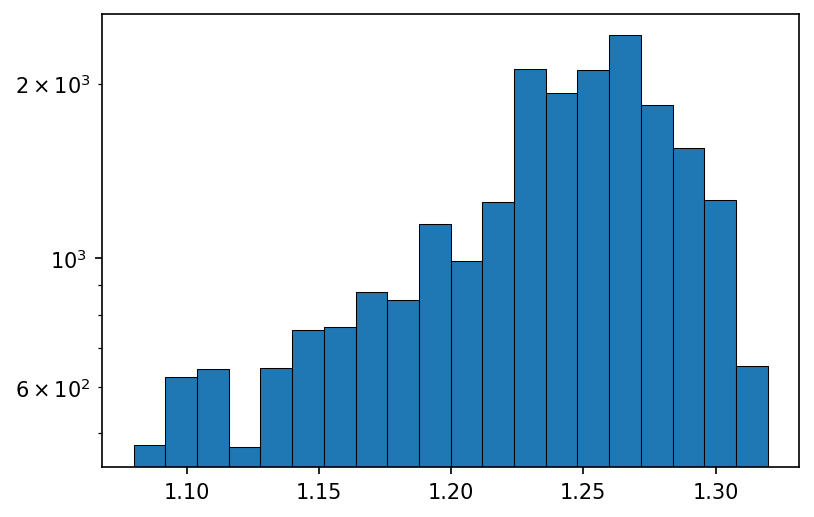

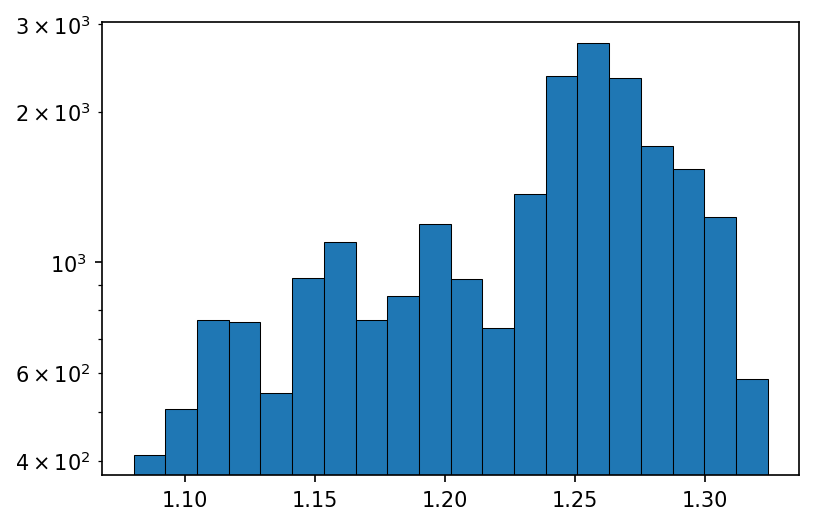

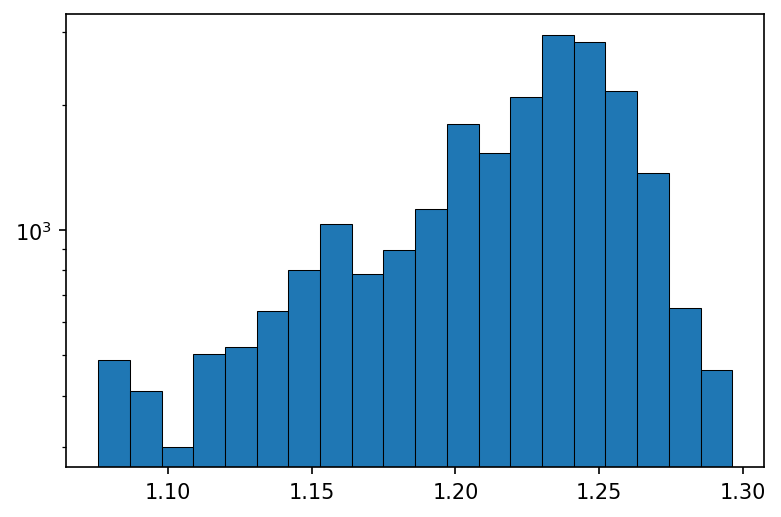

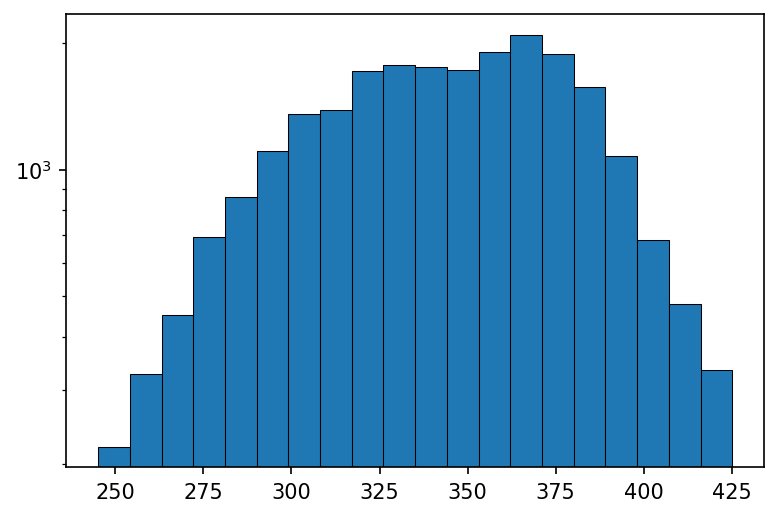

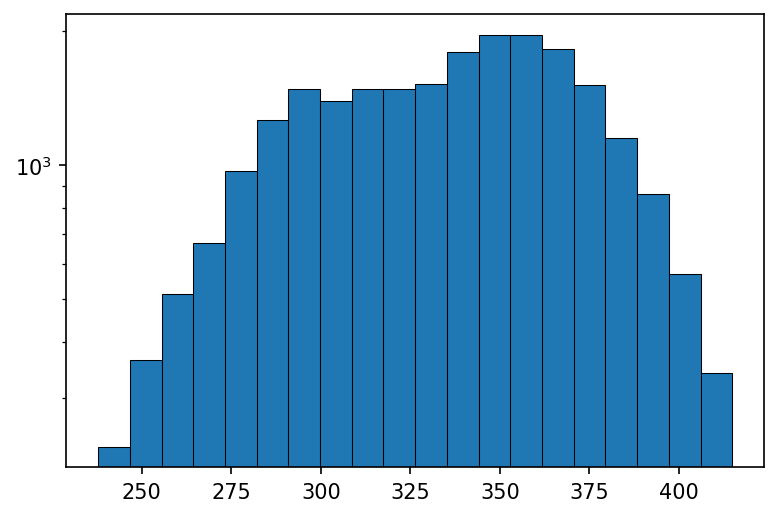

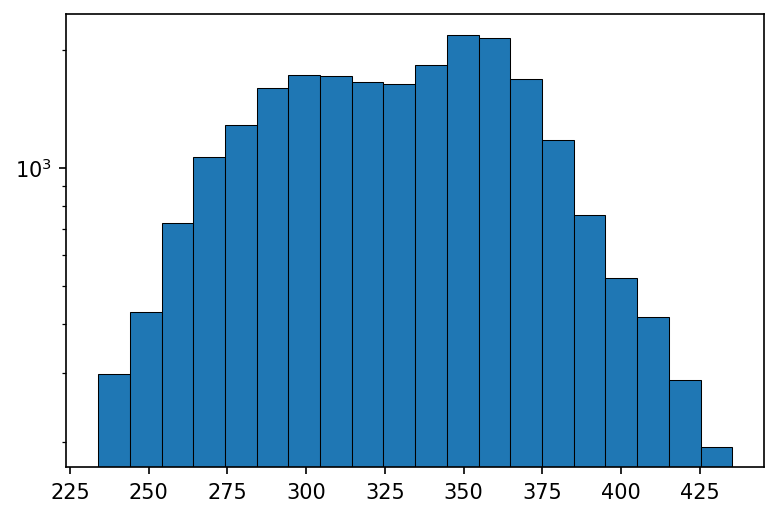

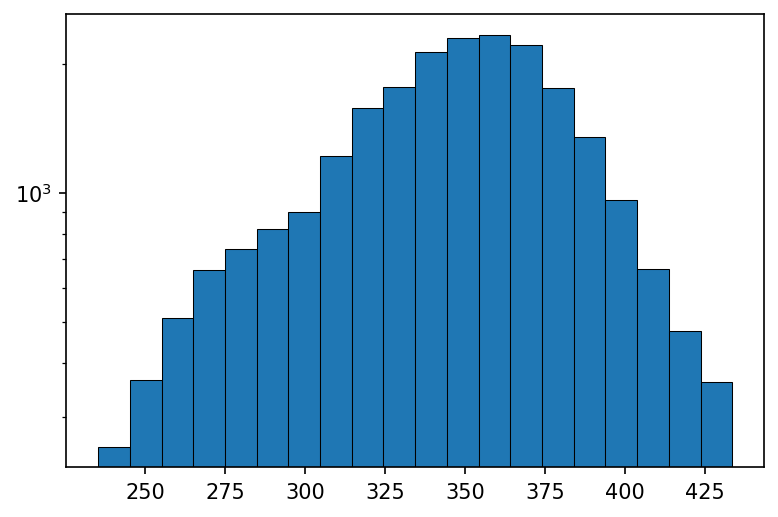

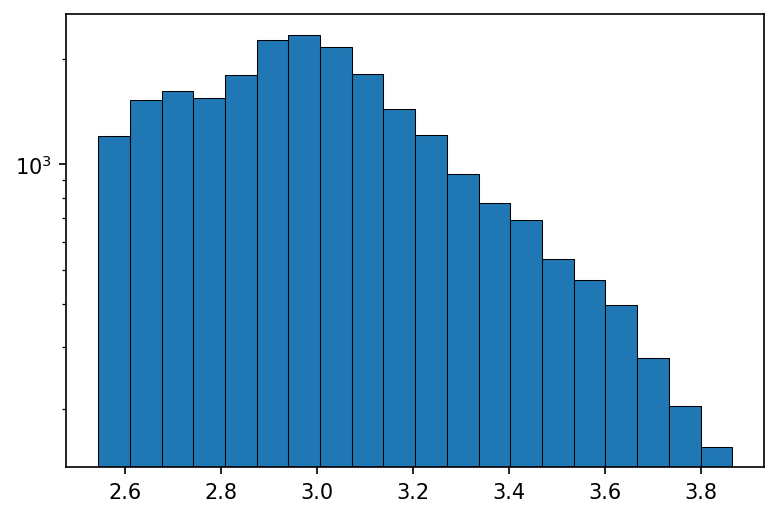

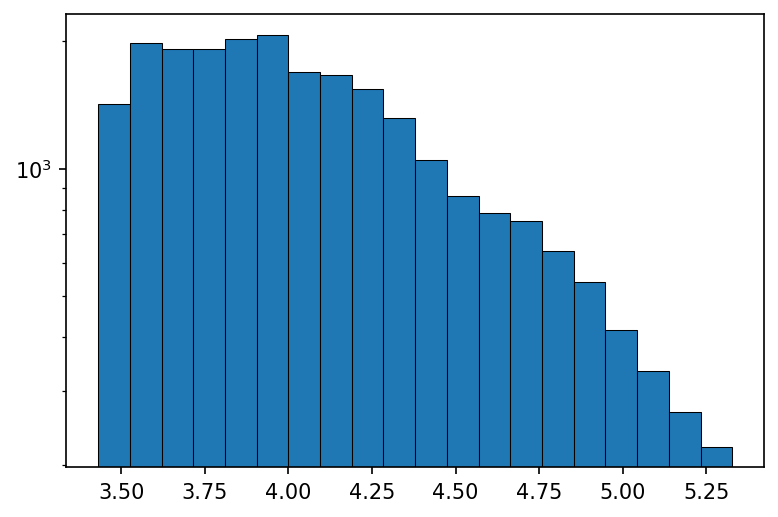

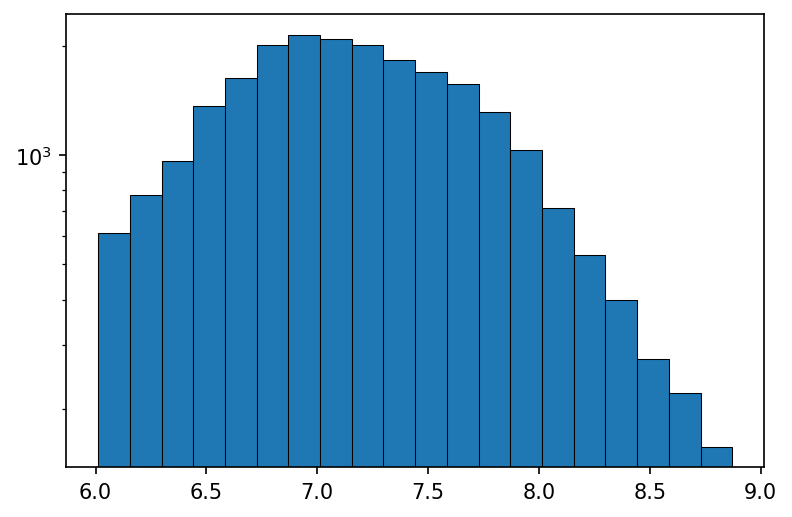

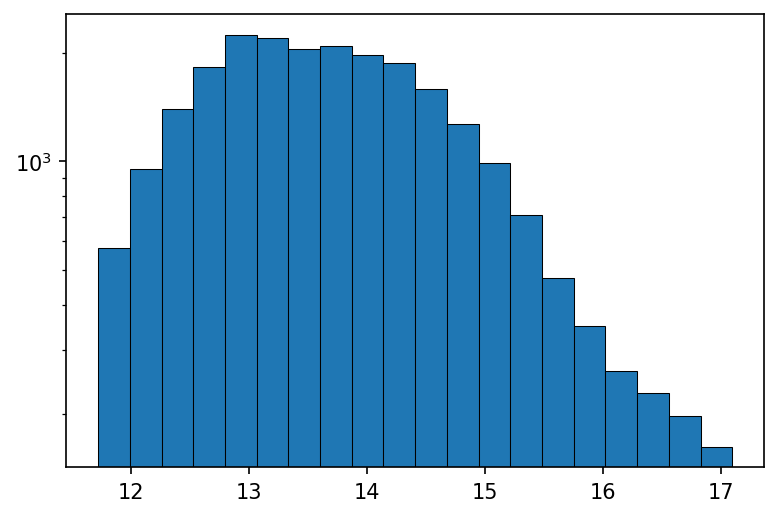

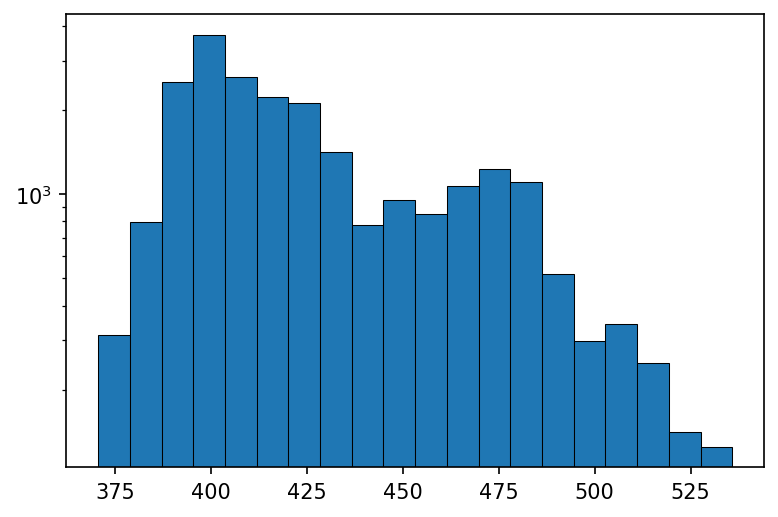

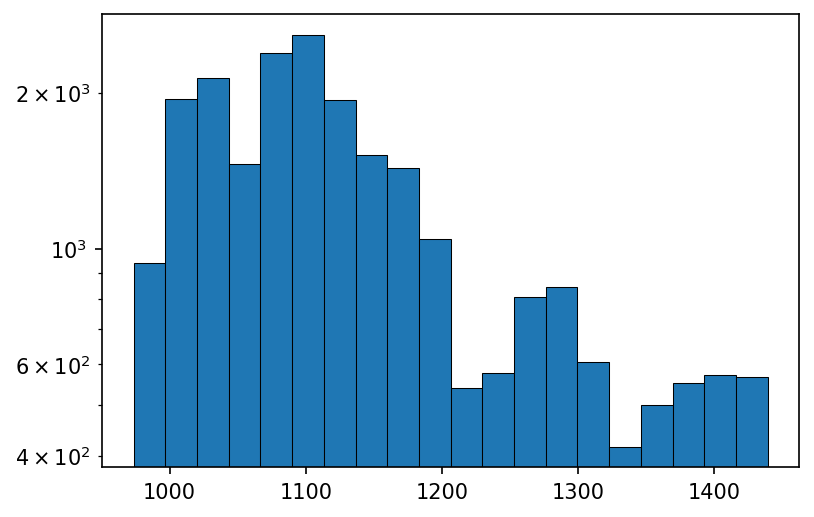

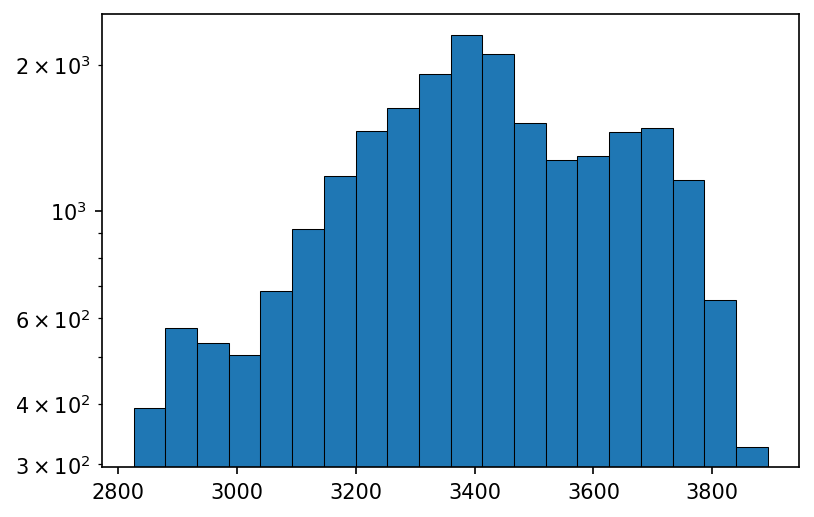

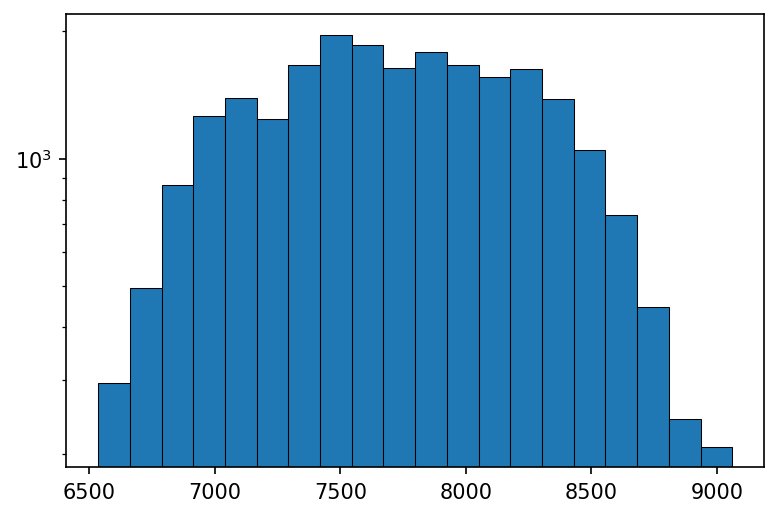

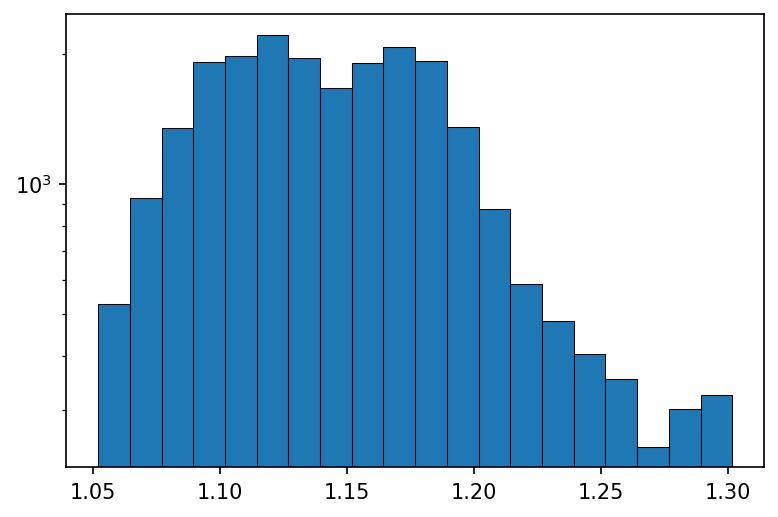

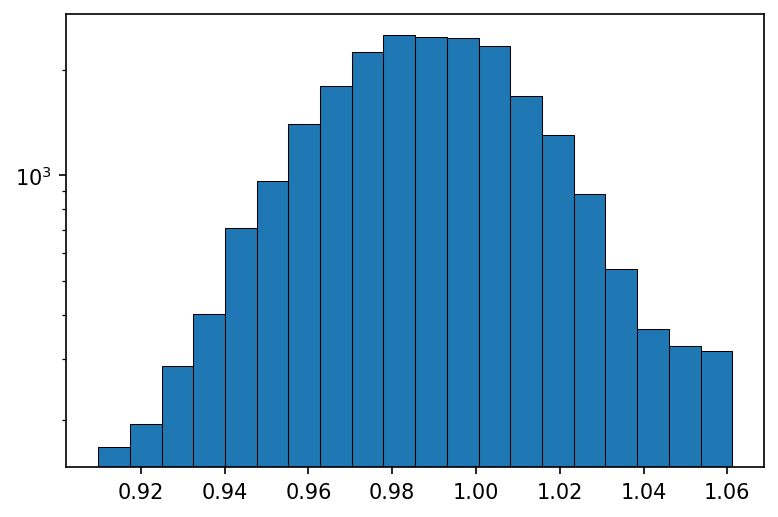

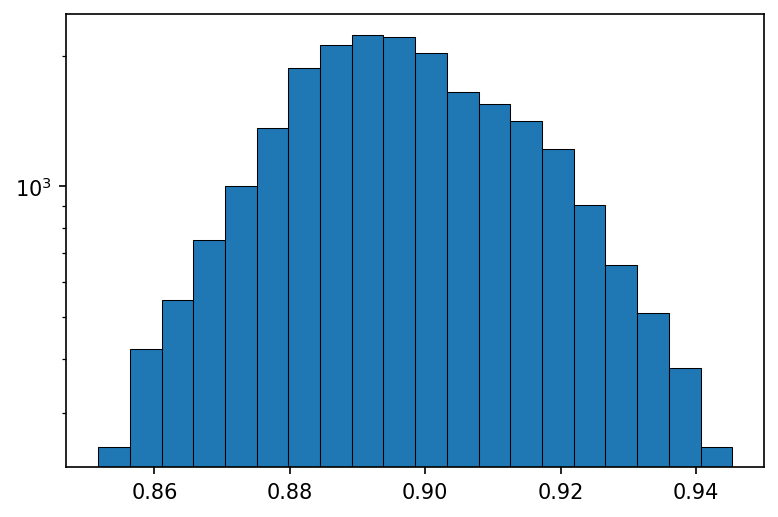

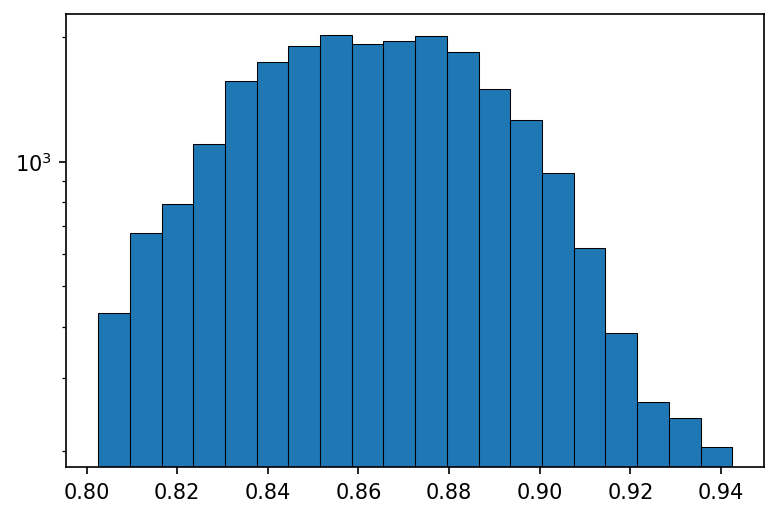

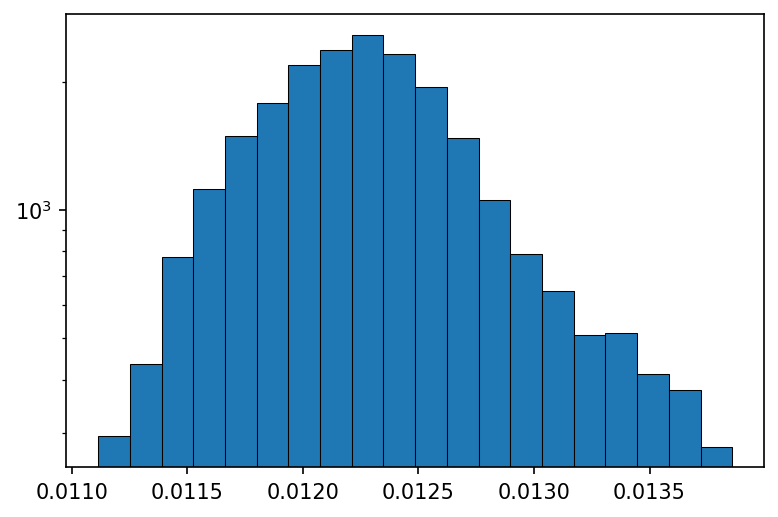

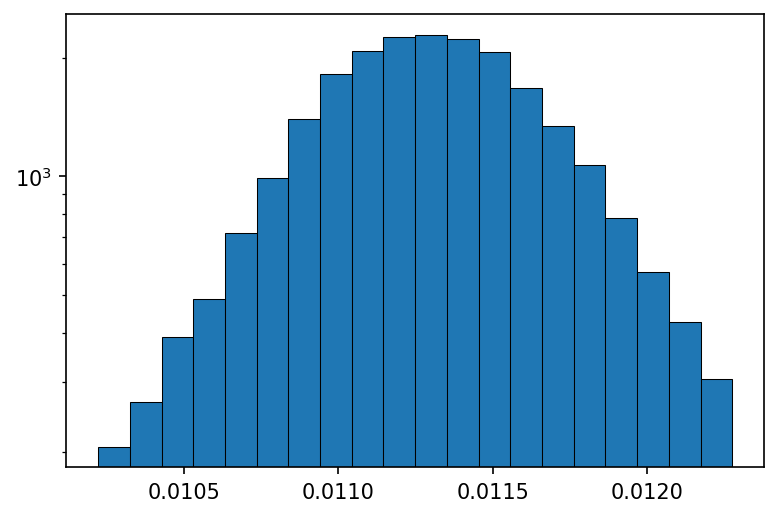

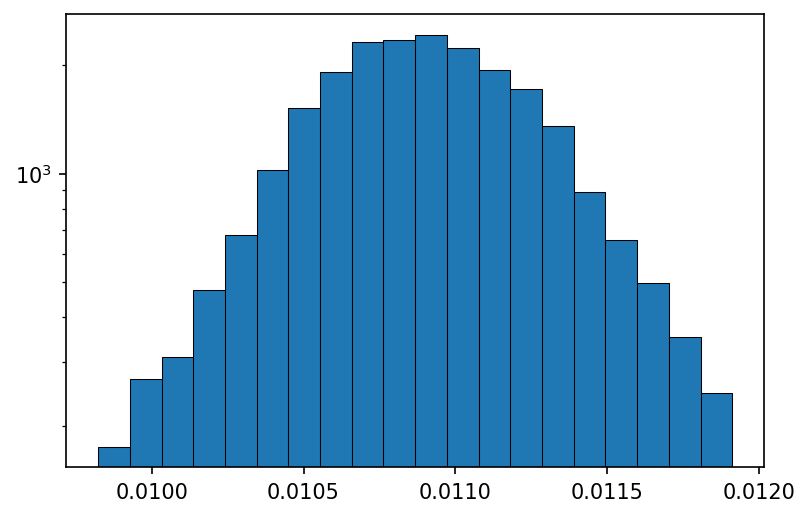

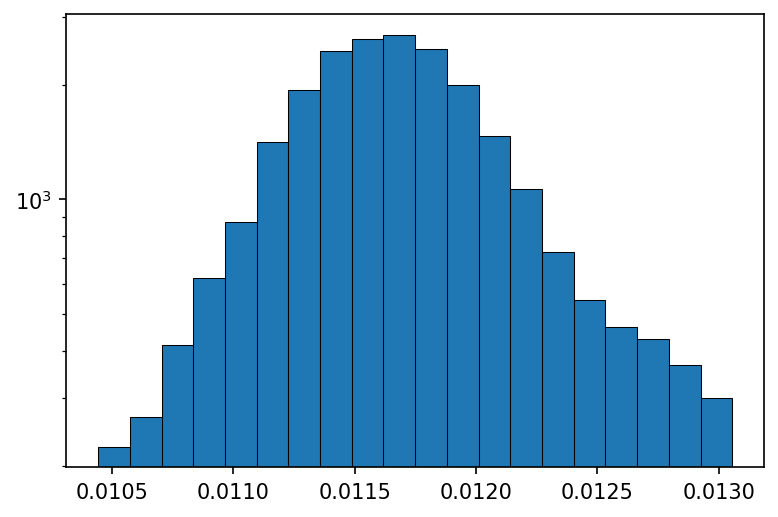

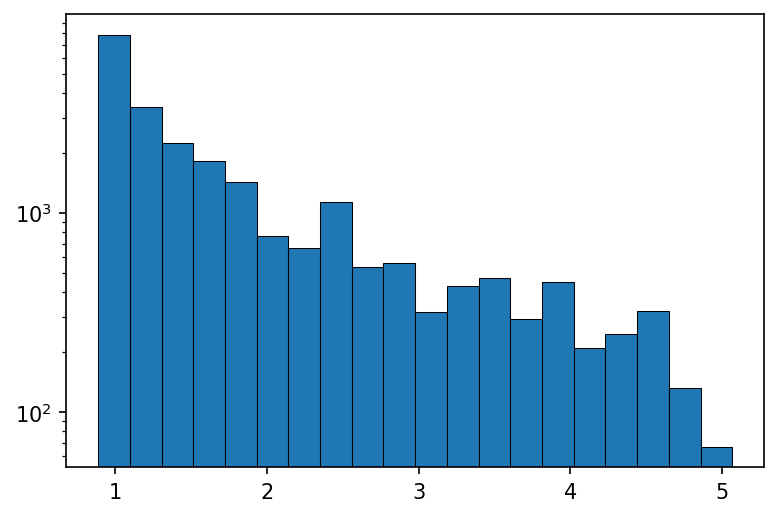

In [17]:
for cond in cond95Per:
    plt.figure(dpi = 150)
    plt.hist(cond, bins = 20, edgecolor='black', linewidth=.5)
    plt.yscale('log')
    plt.show()

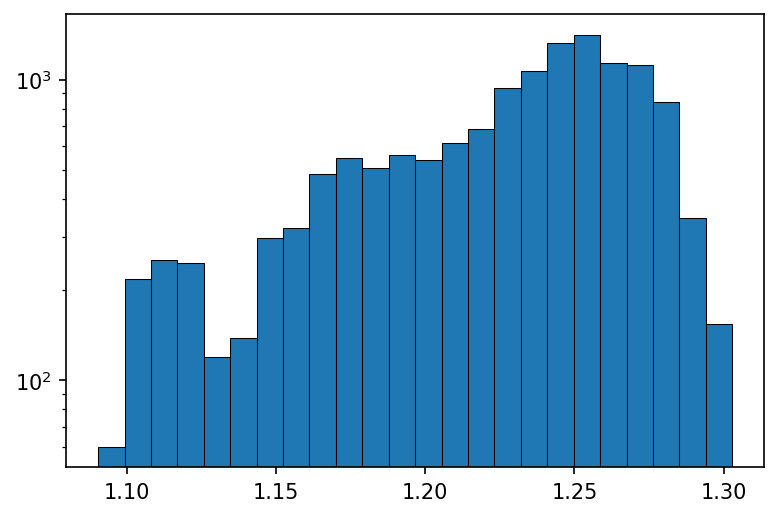

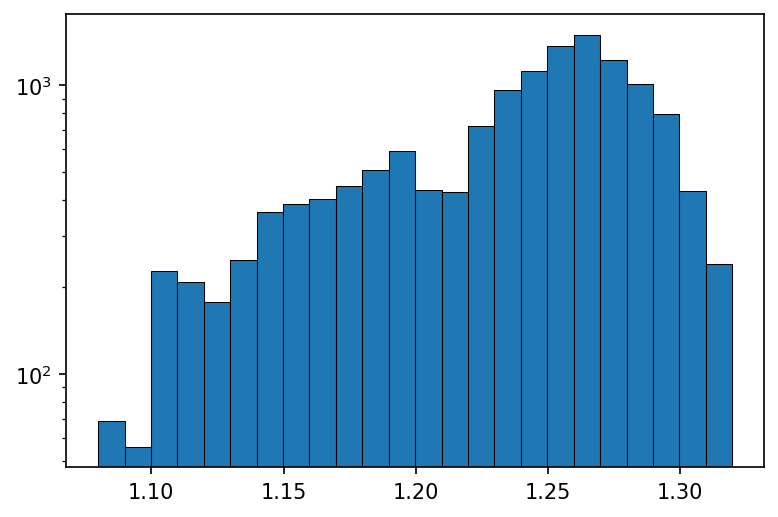

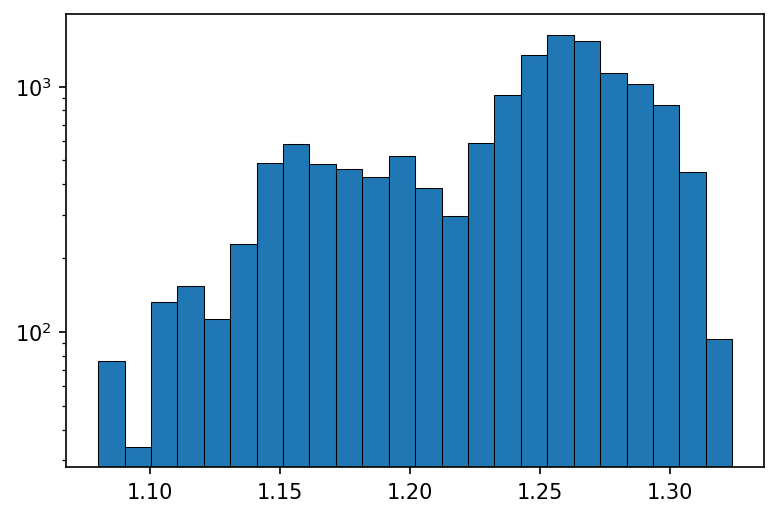

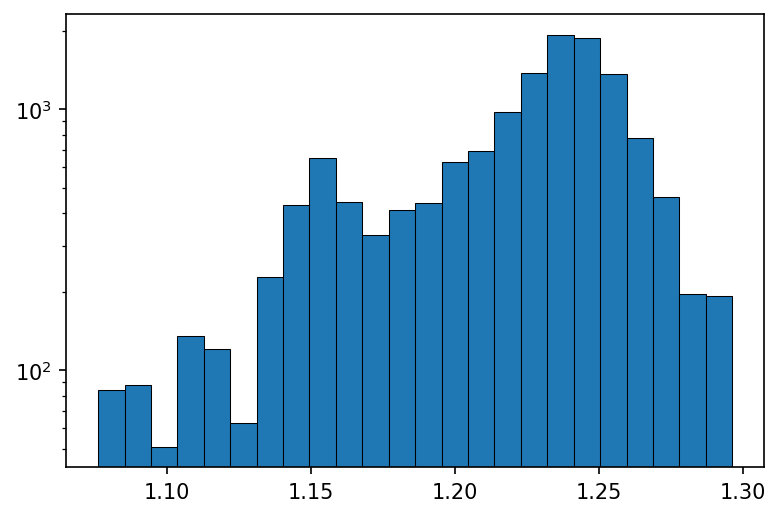

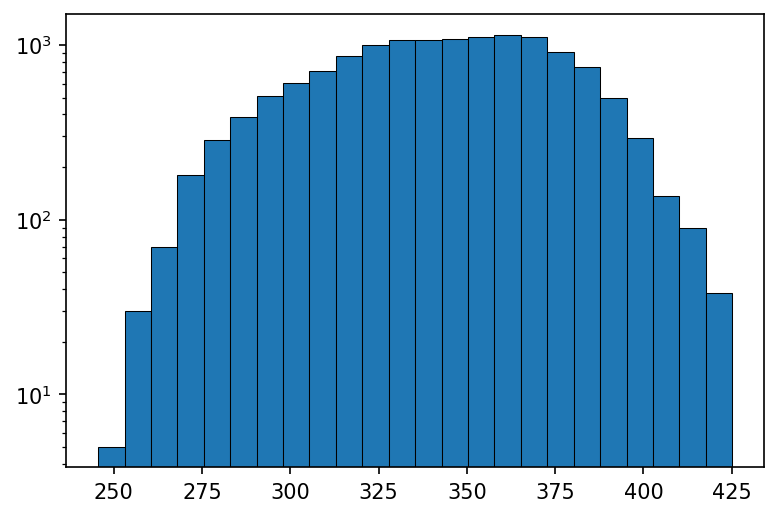

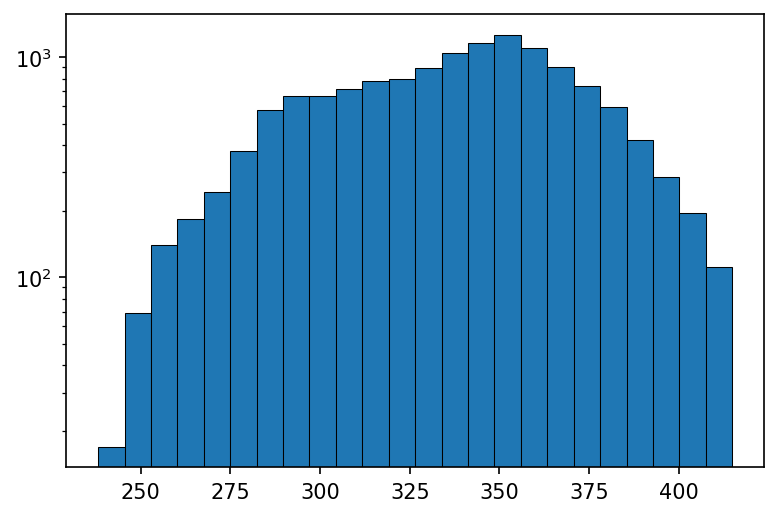

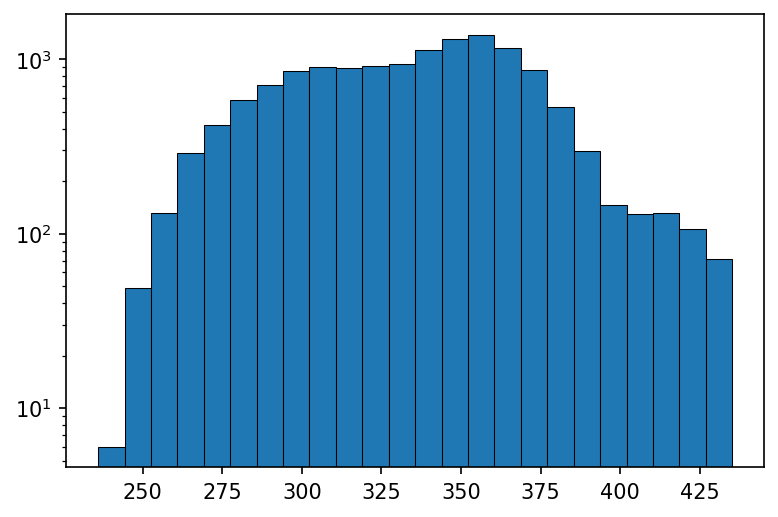

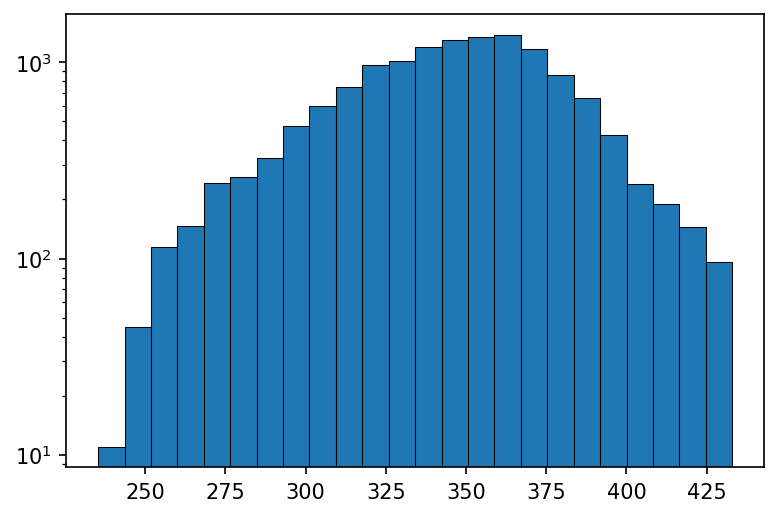

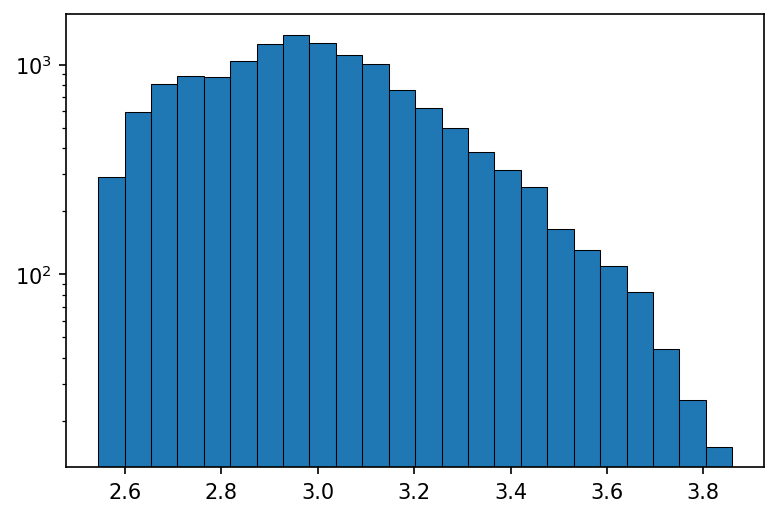

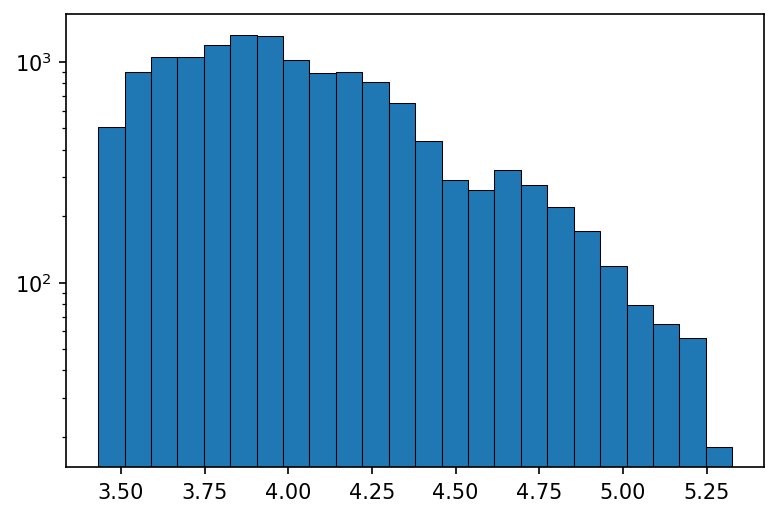

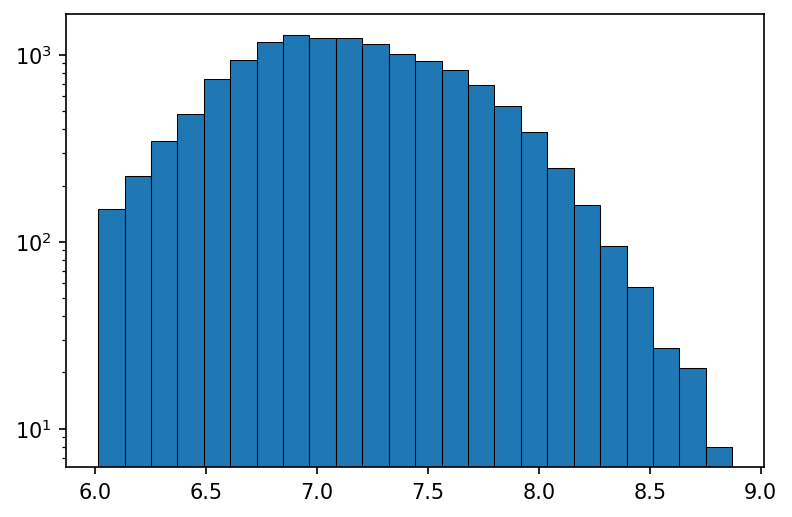

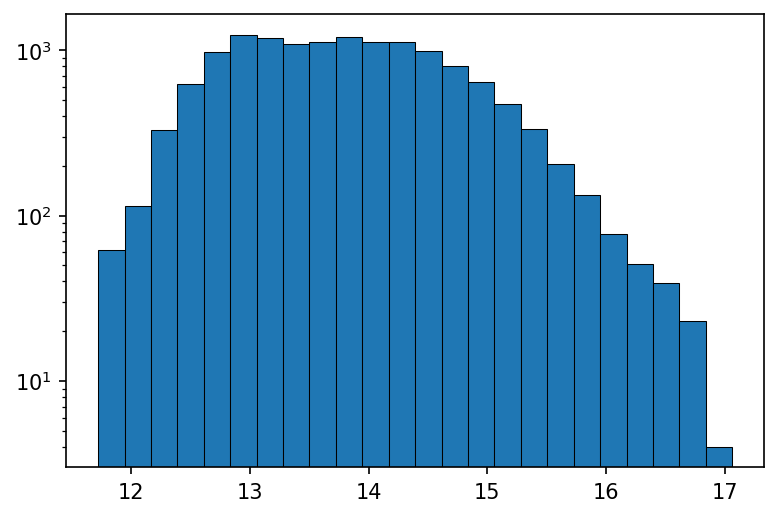

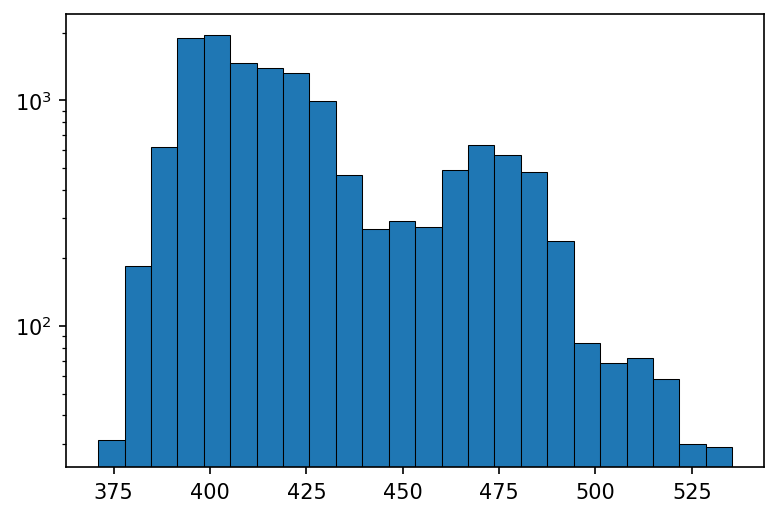

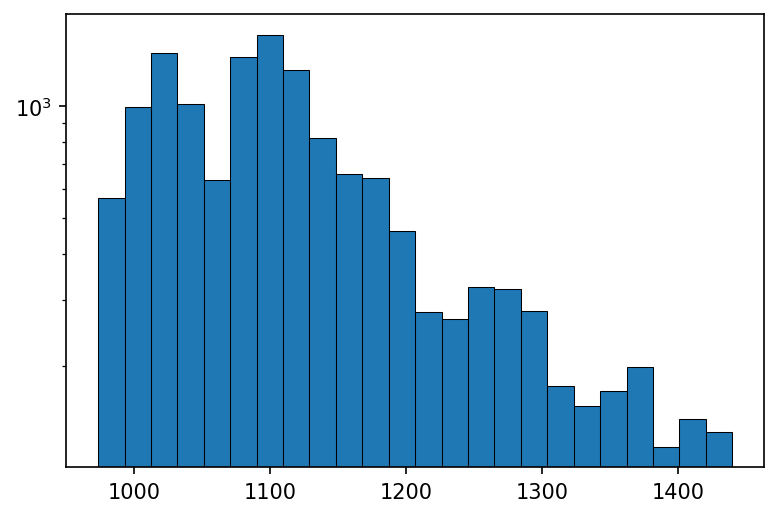

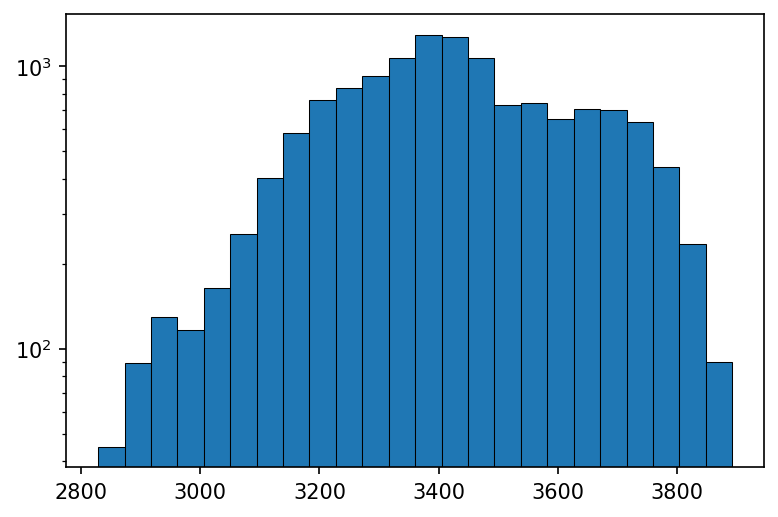

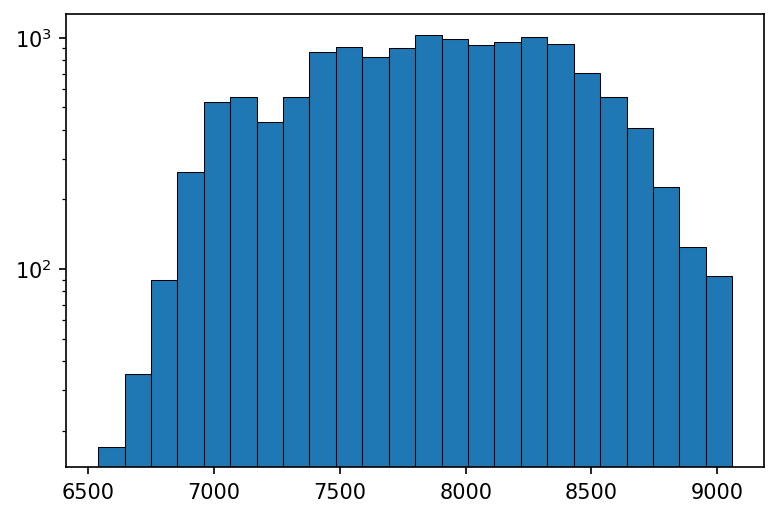

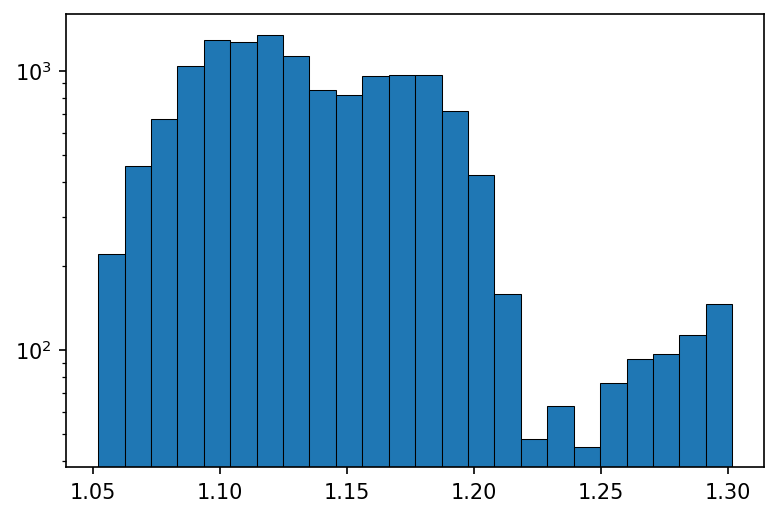

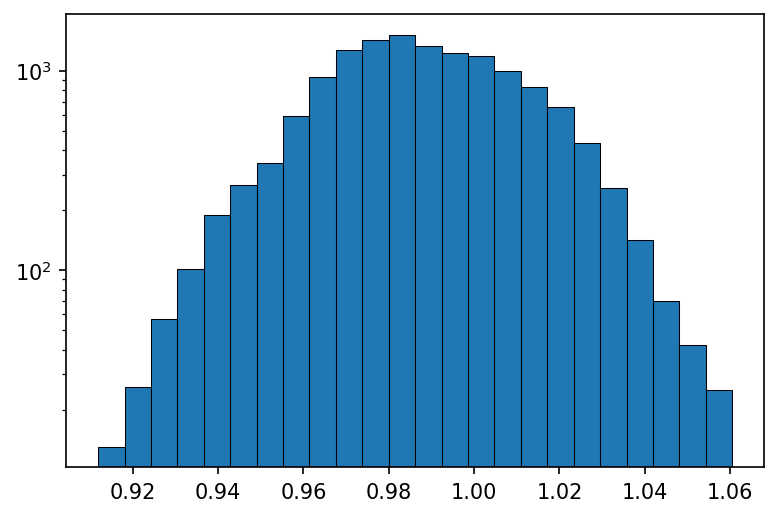

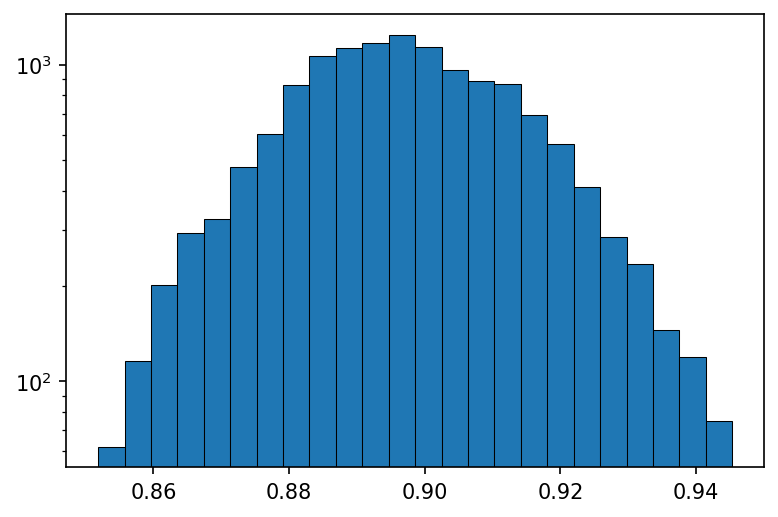

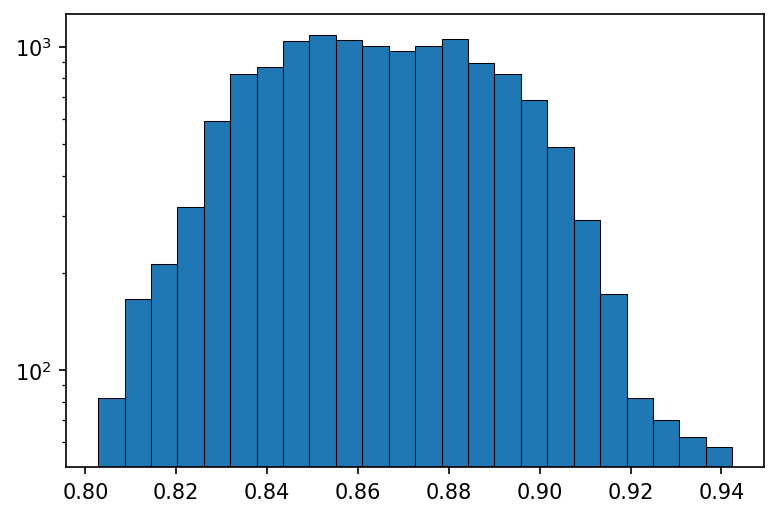

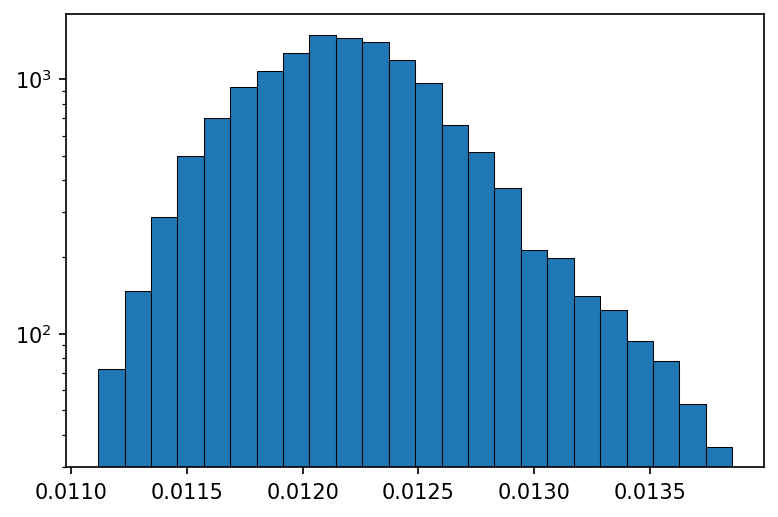

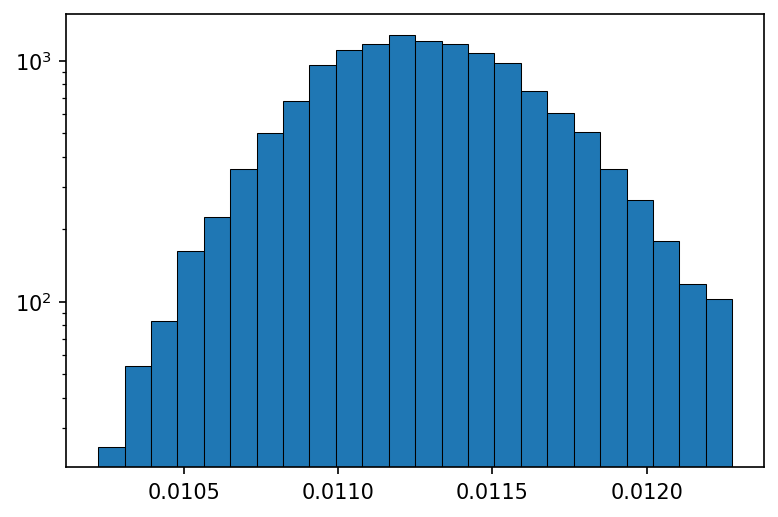

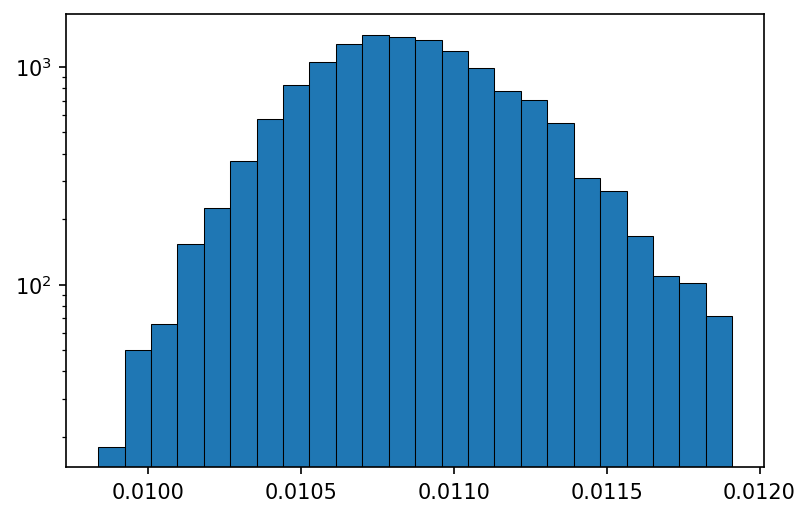

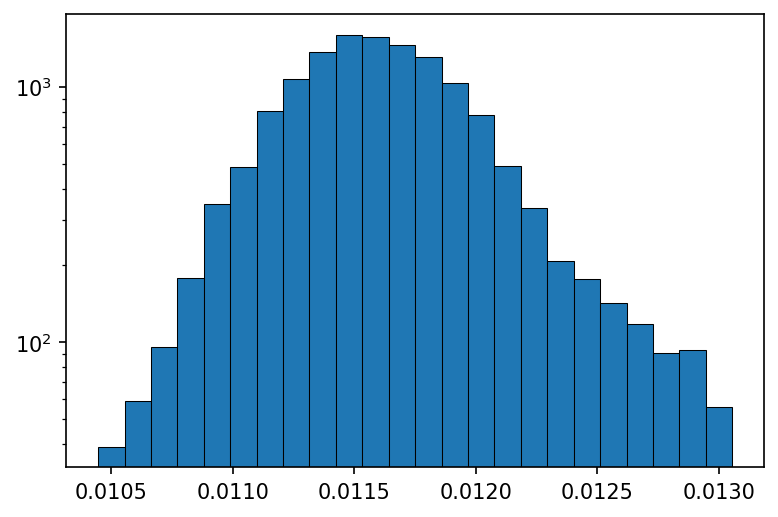

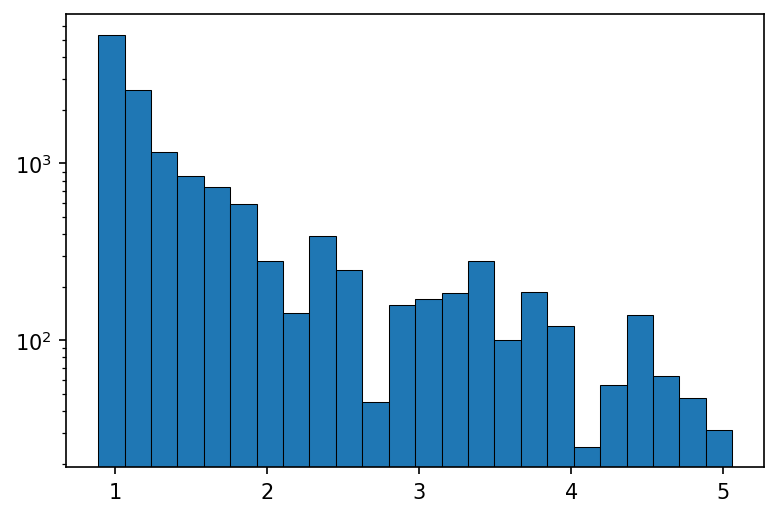

In [18]:
for cond in condSigsExt:
    condSig = cond[VP]
    plt.figure(dpi = 150)
    plt.hist(condSig, bins = 24, edgecolor='black', linewidth=.5)
    plt.yscale('log')
    plt.show()

In [19]:
finalPixels = VP
# This gets the indices of the stars that are at valid pixels (this shouldn't filter out many at all).
finalStarIndices = np.where(finalPixels[starPixels])[0]

In [20]:
# This tells me which pixels correspond to the values above.
finalCondPix = np.where(finalPixels)[0]

# This tells me the pixels for the stars, it will be the same as condPix but have repeats if multiple stars are detected
# on one pixel. By default these will not be sorted.
finalStarPix = starPixels[finalStarIndices]
FINALDETVALIDPIX = DETECTED[starIndices]

# This sorts the pixels. This may seem like an unnecessarily difficult way to do it but it could be useful for future projects
# and it doesn't take much more space or time so I chose to leave it in.
finalSortInds = finalStarPix.argsort()
finalStarPix = finalStarPix[finalSortInds[::1]]
FINALDET = FINALDETVALIDPIX[finalSortInds[::1]]

In [21]:
# These are indices that will be looping through the condPix and starPix arrays in parallel.
finalCondInd = 0
finalStarInd = 0

# This will be used to store the number of stars at each pixel.
finalDetStar = np.zeros_like(finalCondPix) + 1 # Laplace's Rule of Succession
finalInjStar = np.zeros_like(finalCondPix) + 2 # Laplace's Rule of Succession

while finalStarInd < len(finalStarPix):
    if finalCondPix[finalCondInd] == finalStarPix[finalStarInd]: # If the pixels match up in the arrays.
        finalDetStar[finalCondInd] += FINALDET[finalStarInd]
        finalInjStar[finalCondInd] += 1                # Add one to the corresponding spot in the balStar array.
        finalStarInd += 1                         # Add one to the starInd to see if the next index in starPix is also the same.
        # Since the last index of condPix and starPix are the same, starInd will increase the last time through the loop,
        # making this the index that we must restrict in the while loop.
    else:
        finalCondInd += 1 # If the pixels are no longer the same, increase the index you check in the condPix array.

In [22]:
finalConds = []

for cond in condSigsExt:
    condSig = cond[VP]
    finalConds.append(condSig)
    
finalConds = np.array(finalConds)

In [23]:
numBins = 12

In [24]:
def binIndicesByCondition(cond, condMin, condMax, numBins): # This bins together the indices.
    binBounds = np.linspace(condMin, condMax, (numBins + 1), endpoint = True)
    indByBin = []
    for i in range(len(binBounds) - 1):
        validIndices = np.array(np.where((cond >= binBounds[i]) & (cond <= binBounds[i + 1]))[0])
        # I used both >= and <= even though this could result in repeats since what we're after is the "detection efficiency"
        # in a certain range of conditions and I didn't think repeats would really matter. Easy switch if desired though.
        indByBin.append(validIndices)
    return np.array(indByBin, dtype = object)

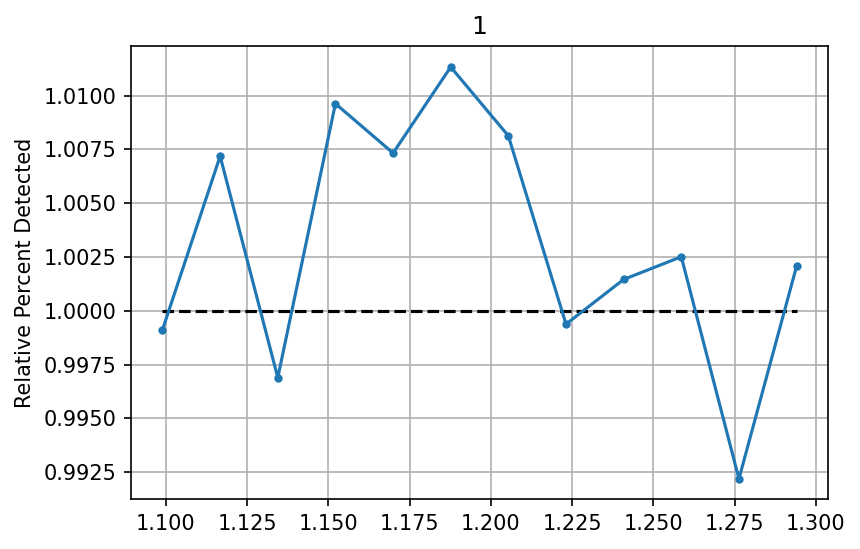

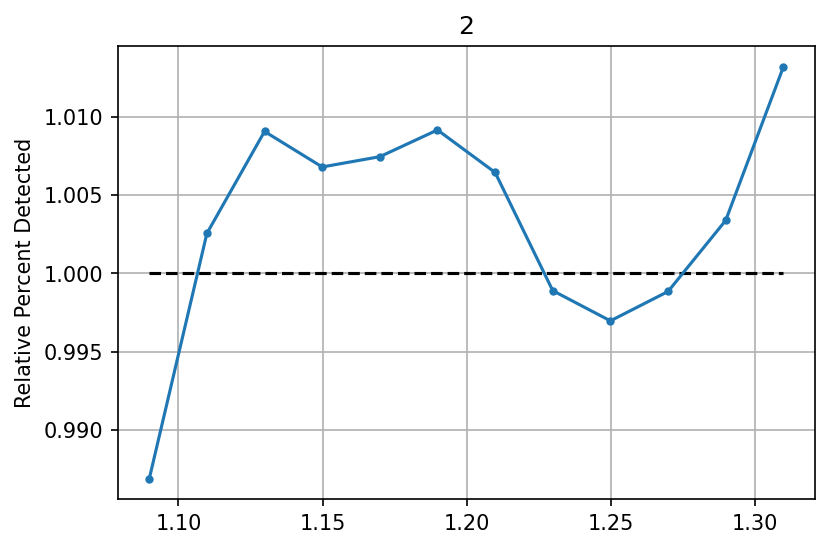

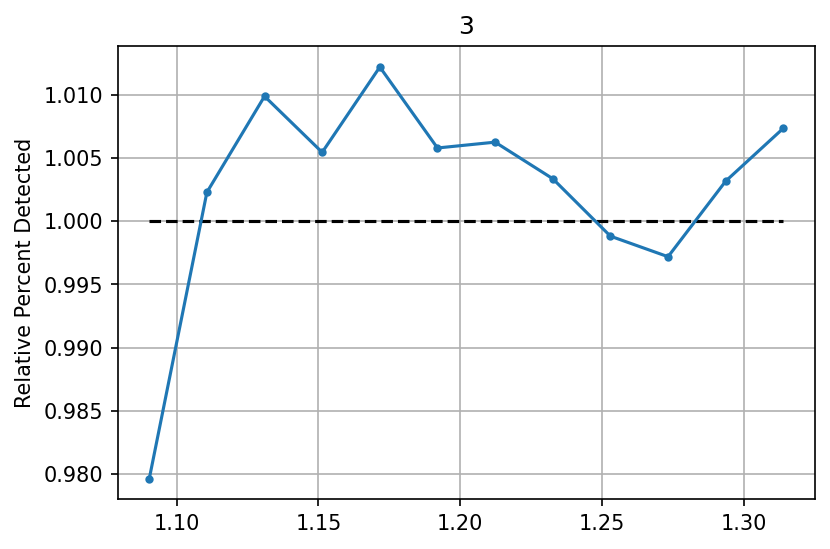

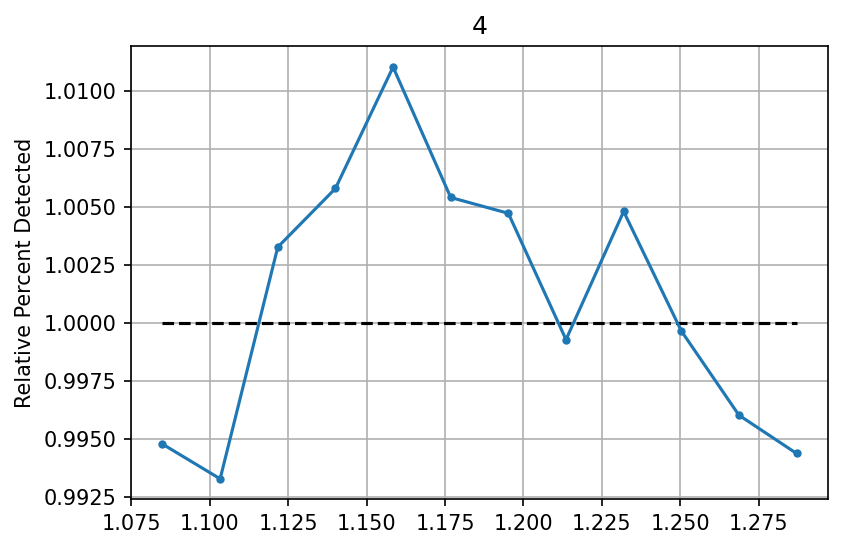

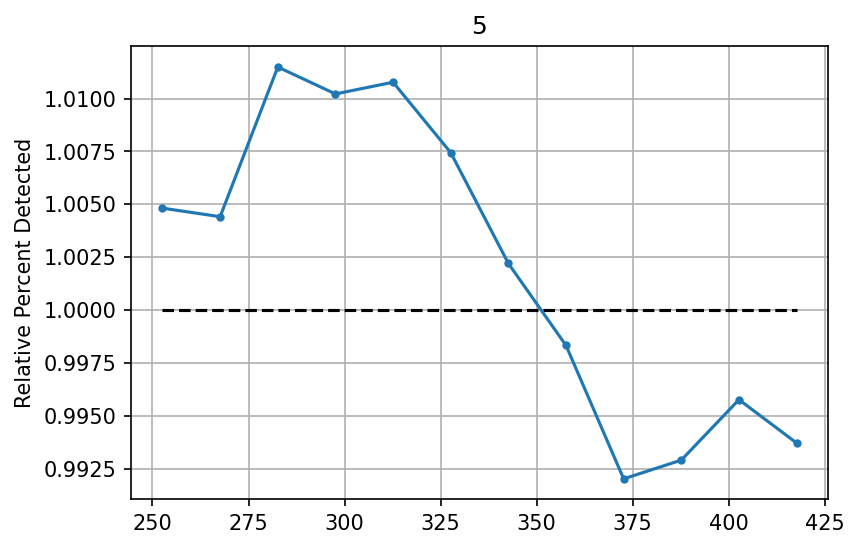

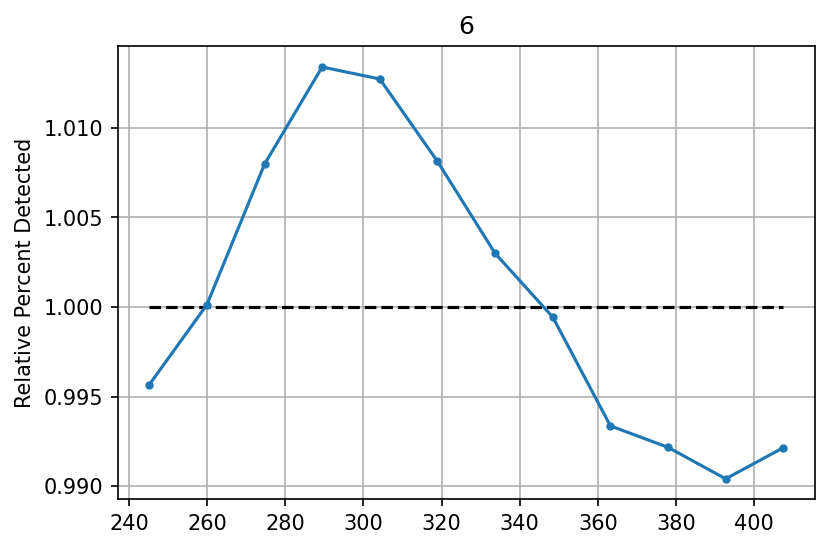

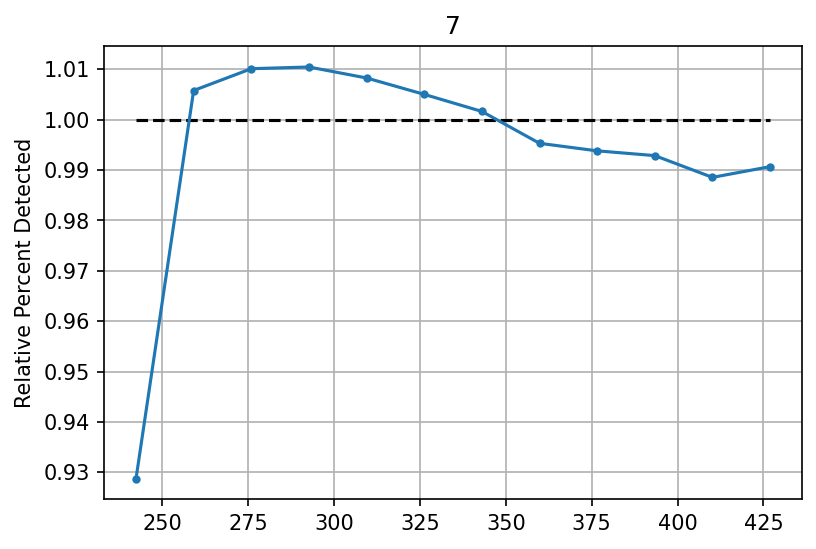

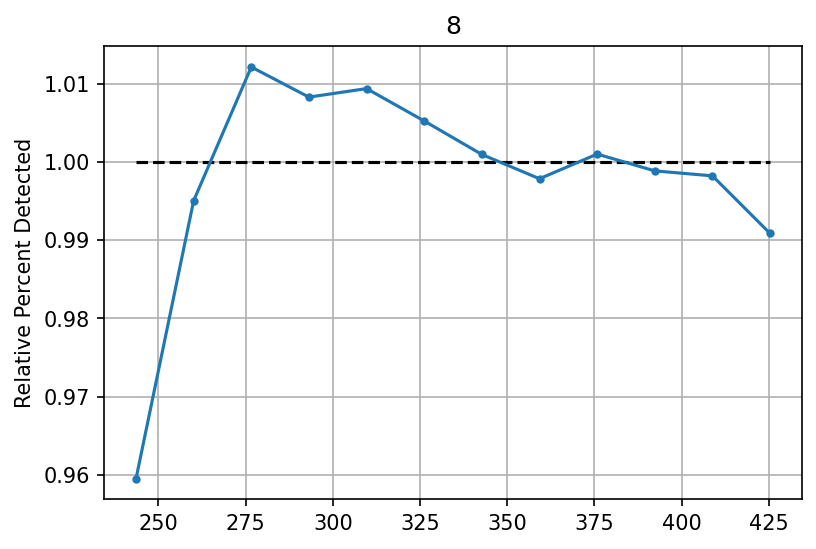

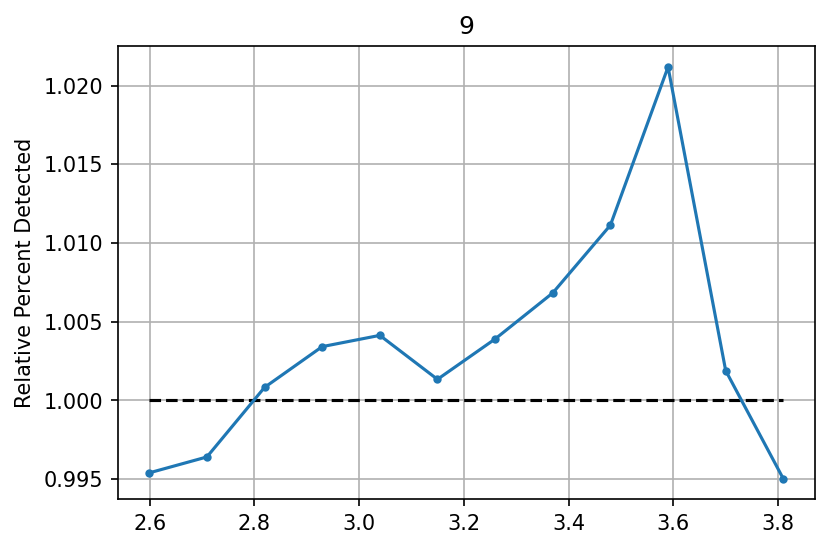

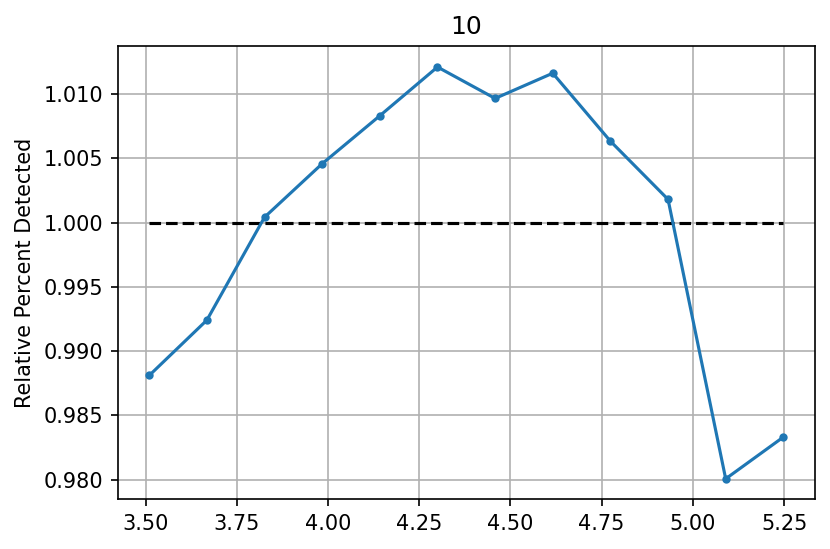

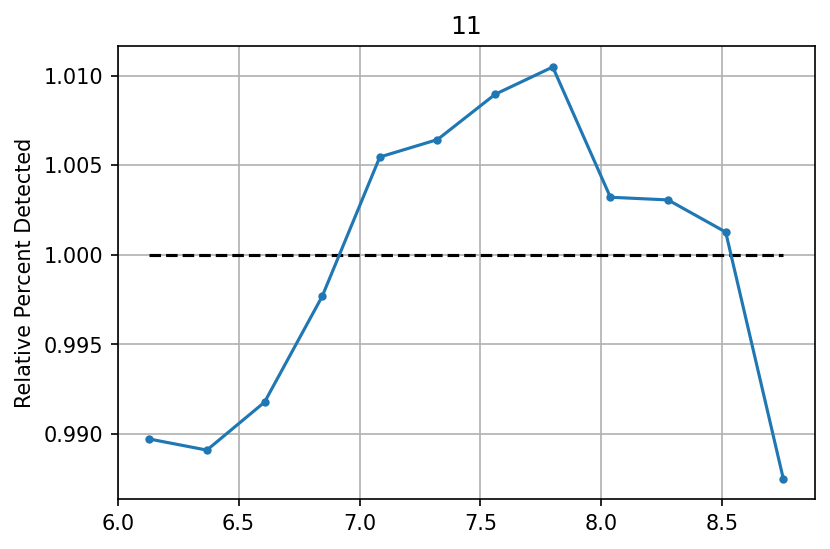

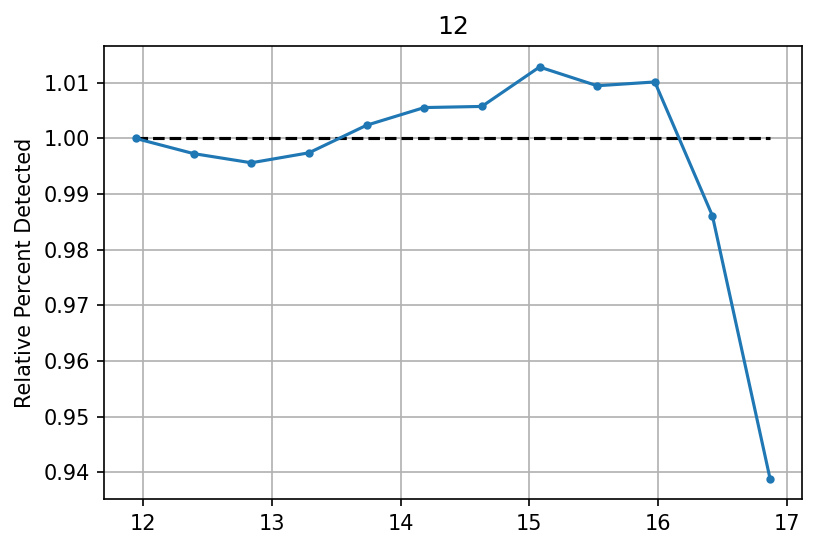

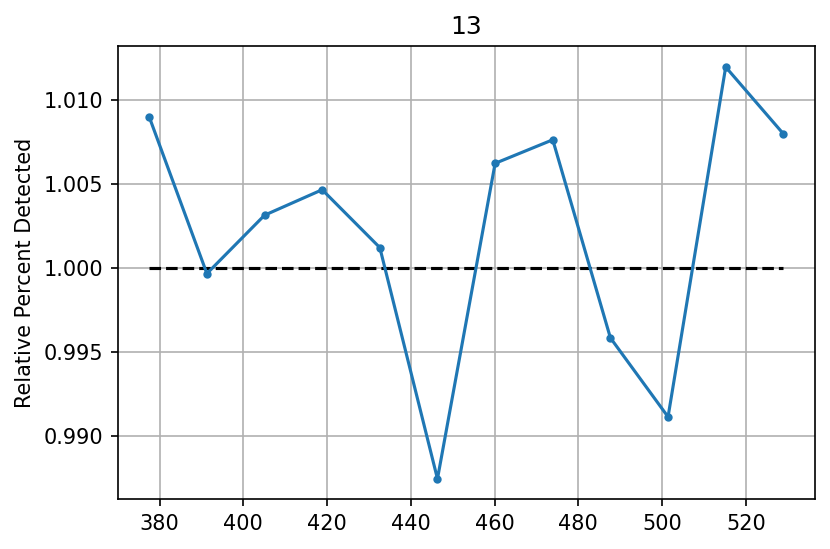

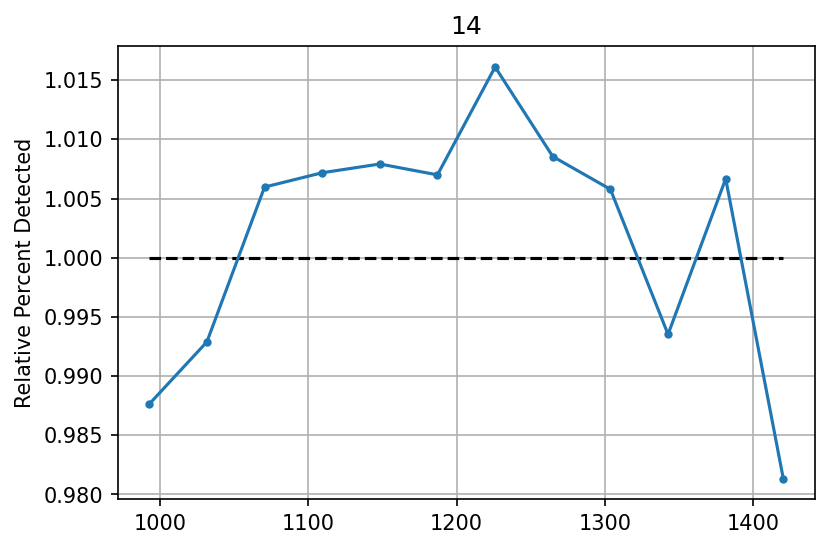

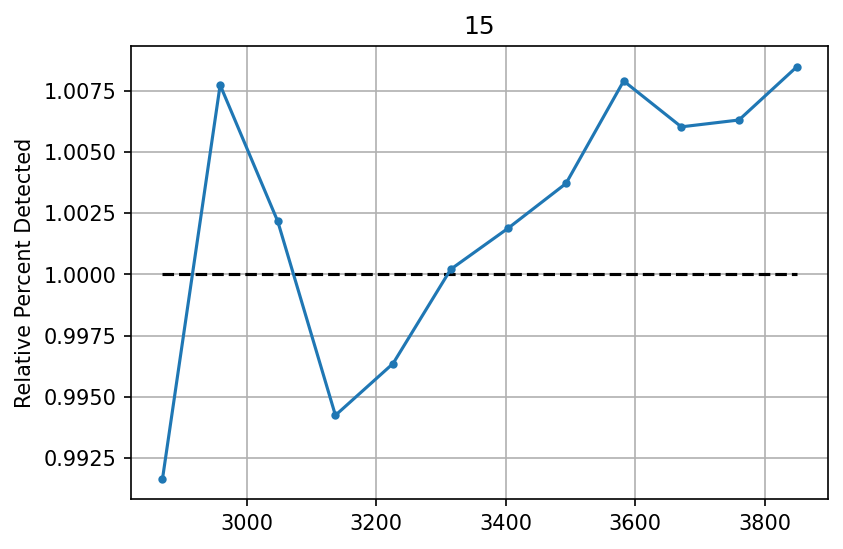

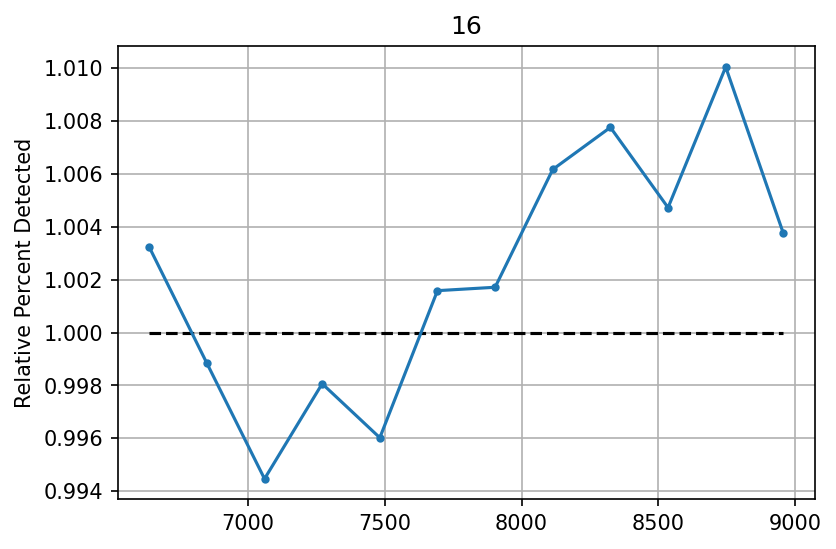

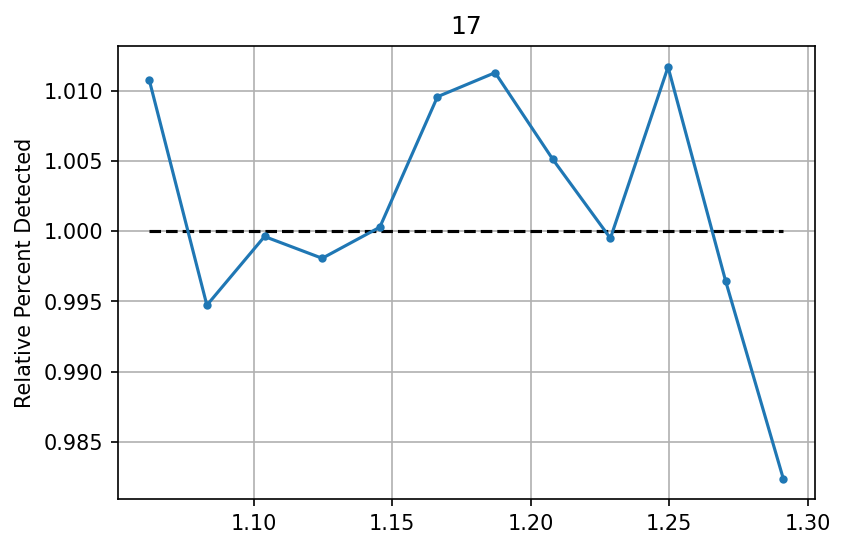

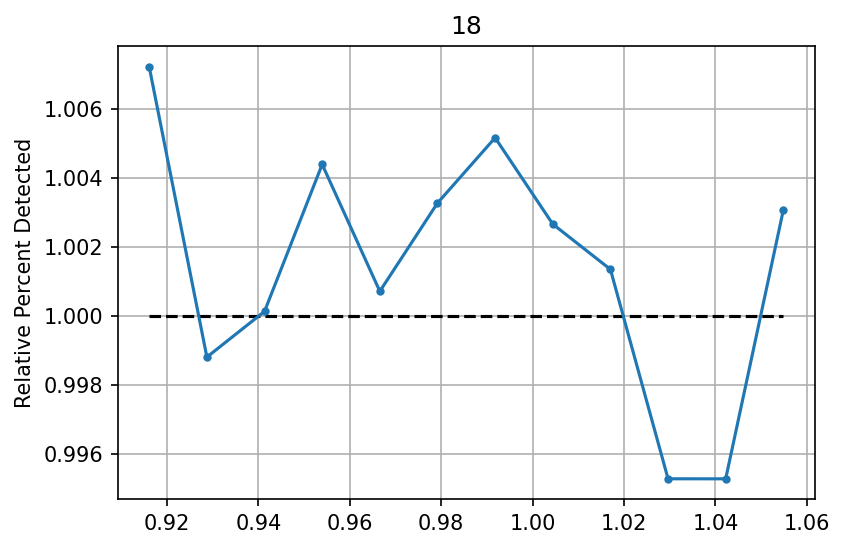

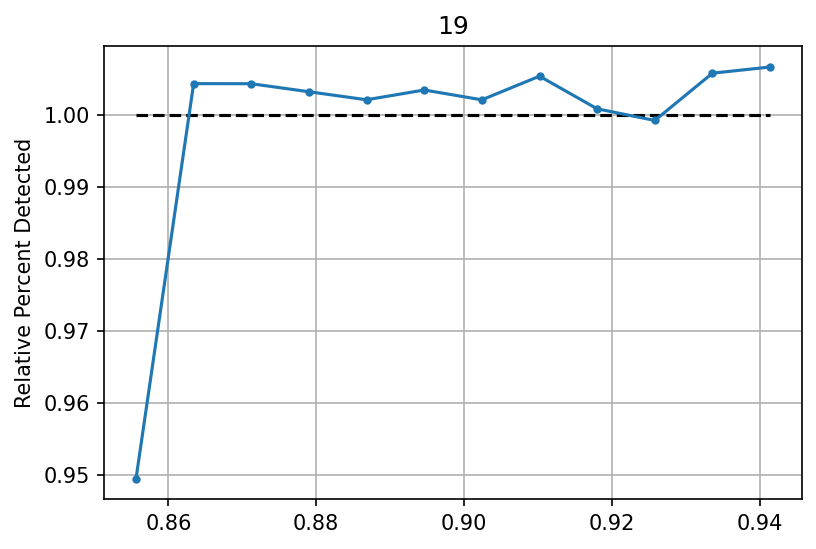

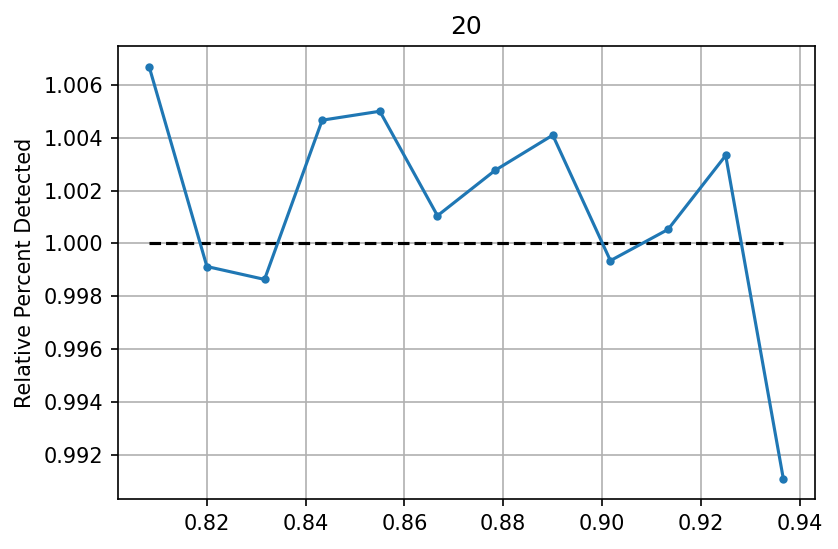

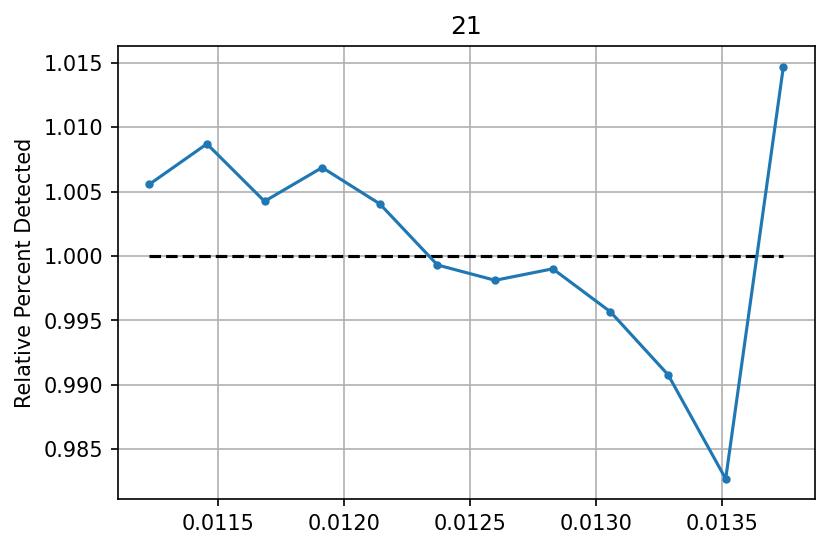

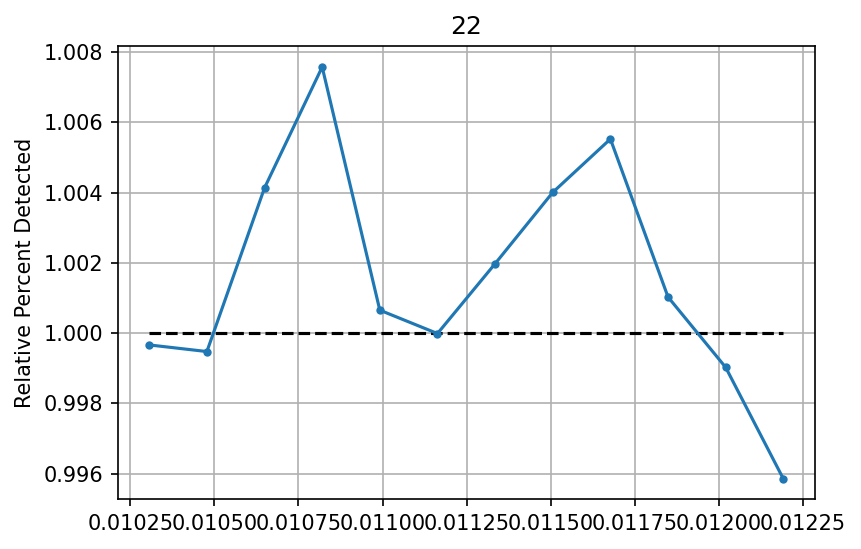

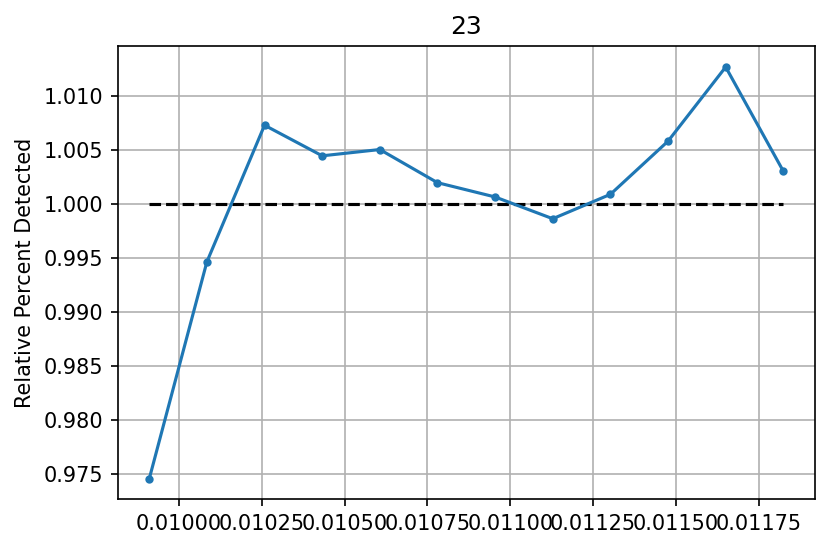

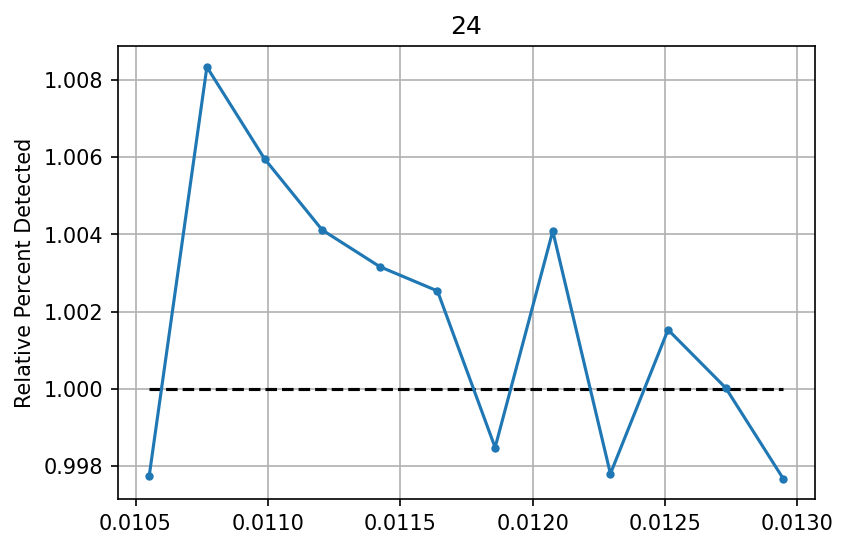

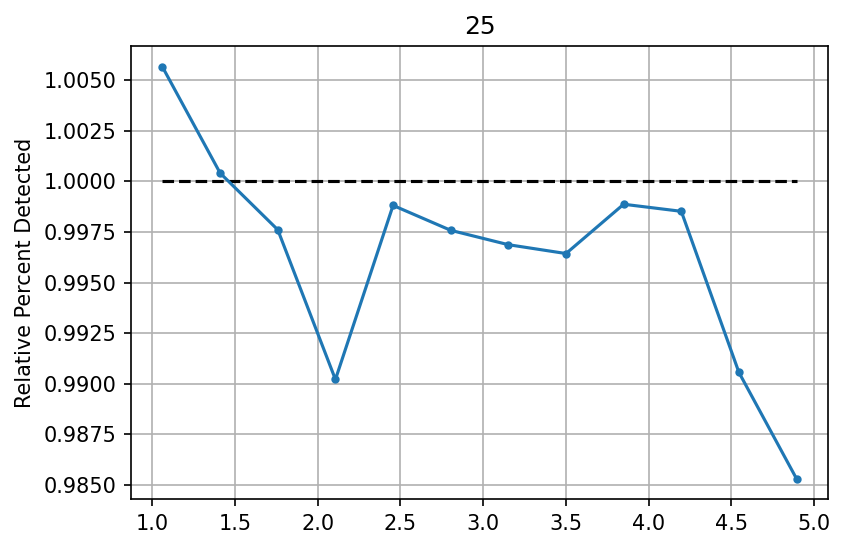

In [25]:
for i in range(len(finalConds)):
    
    # This generates the x values to be used in the final plot as the middle value of each bin.
    xValues = np.linspace(binLims[i][0], binLims[i][1], numBins, endpoint = False) + (binLims[i][1] - binLims[i][0]) / (2 * numBins)
    
    # This generates the indices for each bin.
    binInd = binIndicesByCondition(finalConds[i], binLims[i][0], binLims[i][1], numBins)
    percentBins = []

    for j in range(len(binInd)):
        totalDet = np.sum(finalDetStar[binInd[j]]) # Total number of detections within the bin.
        totalInj = np.sum(finalInjStar[binInd[j]])
        percentBins.append(totalDet / totalInj) # Total effective area within the bin.

    relPerBins = np.array(percentBins) / aveEff # This normalizes the data, relative percent bins.
    
    # This is the final plot.
    plt.figure(dpi = 150)
    plt.plot(xValues, relPerBins, marker = '.', zorder = 3)
    plt.plot(xValues, np.ones_like(xValues), color = 'k', linestyle = '--')
    # plt.ylim([0.6, 1.3])
    plt.title(str(i + 1))
    plt.ylabel('Relative Percent Detected')
    plt.grid()
    plt.show()